<a href="https://colab.research.google.com/github/antonshalin76/DataScientist/blob/main/Classification/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D0%B6%D0%B0%D0%BD%D1%80%D0%BE%D0%B2_%D0%BF%D0%BE_%D1%84%D1%80%D0%B0%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D1%83_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D0%B4%D0%BE%D1%80%D0%BE%D0%B6%D0%BA%D0%B8_Conv1D_%D1%81%D0%BE_%D1%81%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B8%D0%BC_%D0%BE%D0%BA%D0%BD%D0%BE%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сделать классификатор с точностью классификации жанра на тестовых данных не ниже **60%**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gdown, os, time, random, math, gc, pickle, librosa
from tensorflow.keras.utils import to_categorical
from google.colab import files
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, SpatialDropout1D
from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip', None, quiet=True)
# Распаковка архива на локальный диск colab
!unzip -qo genres.zip

In [ ]:
# Установка констант

FILE_DIR = './genres'                     # Папка с файлами датасета
CLASS_LIST = os.listdir(FILE_DIR)         # Список классов, порядок меток не определен!
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.12                   # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
N_FFT = 16536                             # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков
EPOCHS=50
BATCH_SIZE=4096

In [ ]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

    # Сборка признаков в общий список:
    # На один файл несколько векторов признаков, количество определяется
    # продолжительностью аудио и параметром hop_length в функциях расчета признаков
    features = {'rmse': rmse,
                'spct': spec_cent,
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc,
                'stft': chroma_stft}

    return features


# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T


# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label


# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{class_name}.{str(file_index).zfill(5)}.au'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index,
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, np.array(x_list).astype('float32'), np.array(y_list).astype('float32')
                 #aug(np.array(x_list).astype('float32'))


# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, file_index, duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

# Аугментация

def aug(data):

    # Квадрат значений
    _sqr = f'{data}'+'_sqr'
    _sqr = data ** 2

    # Квадратный корень из модулей значений
    _sqrt = f'{data}'+'_sqrt'
    _sqrt = np.abs(data) ** 0.5

    # Обратная величина
    _inv = f'{data}'+'_inv'
    _inv = 1. / data

    # Квадрат обратной величины
    _qinv = f'{data}'+'_qinv'
    _qinv = 1. / (_sqr)

    # Логарифм квадрата значений
    _log = f'{data}'+'_log'
    _log = np.log(_sqr)

    # Синус значений
    _sin = f'{data}'+'_sin'
    _sin = np.sin(data)

    # Обратный синуса квадрата
    _invqsin = f'{data}'+'_invqsin'
    _invqsin = 1. / np.sin(_sqr)

    # 2 в степени каждого значения
    _exp = f'{data}'+'_exp'
    _exp = 2. ** data

    # Формирование нового тренировочного набора данных
    data = np.hstack([data, _sqr, _sqrt, _inv, _qinv, _log, _sin, _invqsin, _exp])

    # Замена всех бесконечных значений на 0
    data[np.abs(data) == math.inf] = 0

    return data

# Проверка точности на звуковых файлах
# Классификация файла и визуализация предсказания модели для него

def classify_file(model,        # обученная модель классификатора
                  x_scaler,     # настроенный нормировщих входных данных
                  class_index,  # верный индекс класса аудиофайла
                  file_index    # индекс (порядковый номер) аудиофайла в папке
                  ):
    # Подготовка выборки данных файла произведения
    song_name, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC)
    # Нормирование признаков уже настроенным нормировщиком
    file_x_data = x_scaler.transform(file_x_data)

    print('Файл:', song_name)
    print('Векторы для предсказания:', file_x_data.shape)

    # Вычисление предсказания по выборке
    predict = model.predict(file_x_data)
    # Определение среднего предсказания (голосование)
    predict_mean = predict.mean(axis=0)
    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10,3))
    print('Классификация сети:', CLASS_LIST[predict_class_index], '-', 'ВЕРНО :-)' if predict_good else 'НЕВЕРНО.')
    plt.title('Среднее распределение векторов предсказаний')
    plt.bar(CLASS_LIST, predict_mean, color='g' if predict_good else 'r')
    plt.show()
    print('---------------------------------------------------------------')

    # Возврат результата предсказания
    return predict_class_index

# Классификация и визуализация нескольких файлов каждого класса

def classify_test_files(model,       # обученная модель классификатора
                        x_scaler,    # настроенный нормировщих входных данных
                        from_index,  # индекс аудиофайла, с которого начинать визуализацию
                        n_files):    # количество файлов для визуализации
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []
    for class_index in range(CLASS_COUNT):
        for file_index in range(from_index, from_index + n_files):
            predict_class_index = classify_file(model, x_scaler, class_index, file_index)
            y_true.append(class_index)
            y_pred.append(predict_class_index)
            predict_all += 1
            predict_good += (predict_class_index == class_index)

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100., 2)
    print(f'=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ===')

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок по файлам аудио (не нормализованная)')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

In [ ]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)
#x_train_data, y_train_data = extract_data(CLASS_FILES-FILE_INDEX_TRAIN_SPLIT, CLASS_FILES)

# Сохранение train датасета аудио
with open('/content/audio_train_data.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)

files.download('/content/audio_train_data.pickle')
print()

# Формирование тестовой выборки из файлов
x_test, y_test = extract_data(FILE_INDEX_TRAIN_SPLIT, CLASS_FILES)
#x_test, y_test = extract_data(0, CLASS_FILES-FILE_INDEX_TRAIN_SPLIT)

# Сохранение test датасета аудио
with open('/content/audio_test_data.pickle', 'wb') as f:
    pickle.dump((x_test, y_test), f)

files.download('/content/audio_test_data.pickle')

Жанр blues готов -> 395 c
Жанр classical готов -> 385 c
Жанр country готов -> 410 c
Жанр disco готов -> 428 c
Жанр hiphop готов -> 401 c
Жанр jazz готов -> 407 c
Жанр metal готов -> 414 c
Жанр pop готов -> 417 c
Жанр reggae готов -> 425 c
Жанр rock готов -> 428 c


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Жанр blues готов -> 42 c
Жанр classical готов -> 42 c
Жанр country готов -> 42 c
Жанр disco готов -> 45 c
Жанр hiphop готов -> 42 c
Жанр jazz готов -> 42 c
Жанр metal готов -> 42 c
Жанр pop готов -> 42 c
Жанр reggae готов -> 42 c
Жанр rock готов -> 45 c


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0

In [ ]:
# Загрузка подготовленных данных

#url_train = 'https://drive.google.com/uc?id=10pWG3W_ubKHDPDZFwFJnOcYztEaFIiL3'
#url_test = 'https://drive.google.com/uc?id=1IH6-yH7-2l7QN9coBW6PnRtiMb-Eq45d'
url_train = 'https://drive.google.com/uc?id=1Ig9k6PRWtryHzbzt7SXTQ1obJ46n9Q4o'
url_test = 'https://drive.google.com/uc?id=1ReoOD5N9TVvgDPnUqj_VXNhPG0zENIxZ'
#url_train = 'https://drive.google.com/uc?id=1wOlcJvbRHgz_2nMG4JVDHQ4NPezkNd9R'
#url_test = 'https://drive.google.com/uc?id=1zAbkpDertbOV4J_Wa8JTsw0GKb2ZLivq'

#train_file = 'audio_train_data.zip'
#test_file = 'audio_test_data.zip'
train_file = 'audio_train_data16536.zip'
test_file = 'audio_test_data16536.zip'
#train_file = 'audio_train_data16536aug.zip'
#test_file = 'audio_test_data16536aug.zip'

gdown.download(url_train, train_file, quiet=True)
#!unzip -qo audio_train_data.zip
!unzip -qo audio_train_data16536.zip
#!unzip -qo audio_train_data16536aug.zip
with open('/content/audio_train_data.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

gdown.download(url_test, test_file, quiet=True)
#!unzip -qo audio_test_data.zip
!unzip -qo audio_test_data16536.zip
#!unzip -qo audio_test_data16536aug.zip
with open('/content/audio_test_data.pickle', 'rb') as f:
    x_test, y_test = pickle.load(f)

#gc.collect() # почистим память

In [ ]:
with open('/content/audio_train_data.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

with open('/content/audio_test_data.pickle', 'rb') as f:
    x_test, y_test = pickle.load(f)

In [ ]:
# Обогащение данных
#x_train_data = aug(x_train_data)
#x_test = aug(x_test)

# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)
print()
print(x_test.shape, x_test.dtype)
print(y_test.shape, y_test.dtype)

(1023262, 37) float32
(1023262, 10) float32

(139536, 37) float32
(139536, 10) float32

(129200, 37) float32
(129200, 10) float32


In [ ]:
# Зададим колбэки для обучения

earlystop=EarlyStopping(monitor='val_accuracy',
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

reduceLROnPlateau = ReduceLROnPlateau(monitor='val_accuracy',
                                      factor=0.6,
                                      patience=2,
                                      verbose=1)

model_Checkpoint = ModelCheckpoint(filepath='/content/model_conv_audio.h5',
                                   monitor='val_accuracy',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='auto',
                                   baseline=None)

In [ ]:
# Функция сборки и обучения классификатора на сверточных слоях

def create_train_classifier(in_shape,       # форма входных данных модели
                            epochs=EPOCHS,      # количество эпох обучения
                            batch_size=BATCH_SIZE  # размер батча
                            ):

    input1 = Input(x_train.shape[1:])

    x1 = Conv1D(64, 3, activation='relu')(input1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='softmax')(x1)
    x1 = BatchNormalization()(x1)

    x2 = Conv1D(64, 5, activation='relu')(input1)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='softmax')(x2)
    x2 = BatchNormalization()(x2)

    x3 = Conv1D(64, 7, activation='relu')(input1)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='softmax')(x3)
    x3 = BatchNormalization()(x3)

    x4 = Conv1D(32, 3, activation='relu')(input1)
    x4 = Conv1D(32, 3, activation='relu')(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    x4 = Dropout(0.5)(x4)
    x4 = Dense(64, activation='softmax')(x4)
    x4 = BatchNormalization()(x4)

    x5 = Conv1D(32, 3, activation='relu')(input1)
    x5 = Conv1D(16, 5, activation='relu')(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
    x5 = Dropout(0.5)(x5)
    x5 = Dense(64, activation='softmax')(x5)
    x5 = BatchNormalization()(x5)

    x6 = Conv1D(16, 5, activation='relu')(input1)
    x6 = Conv1D(16, 5, activation='relu')(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    x6 = Dropout(0.5)(x6)
    x6 = Dense(64, activation='softmax')(x6)
    x6 = BatchNormalization()(x6)

    x7 = Conv1D(32, 3, activation='relu')(input1)
    x7 = Conv1D(16, 5, activation='relu')(x7)
    x7 = Conv1D(8, 7, activation='relu')(x7)
    x7 = Flatten()(x7)
    x7 = Dense(128, activation='relu')(x7)
    x7 = Dropout(0.5)(x7)
    x7 = Dense(64, activation='softmax')(x7)
    x7 = BatchNormalization()(x7)

    x = concatenate([x1, x2, x3, x4, x5, x6, x7])

    #x = BatchNormalization()(x)
    #x = Dense(256, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(y_train.shape[1], activation='softmax')(x)

    model = Model(input1, x)

    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  #  model.summary()

    # Обучение модели
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(epochs))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    return model

In [ ]:
# Функция сборки и обучения классификатора на сверточных слоях

def create_train_classifier(in_shape,       # форма входных данных модели
                            epochs=EPOCHS,      # количество эпох обучения
                            batch_size=BATCH_SIZE  # размер батча
                            ):

    input1 = Input(x_train.shape[1:])

    x1 = Conv1D(128, 3, activation='relu')(input1)
    x1 = Conv1D(128, 3, activation='relu')(x1)
    x1 = Conv1D(64, 3, activation='relu')(x1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.5)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.5)(x1)
    #x1 = BatchNormalization()(x1)
#    x1 = Dense(10, activation='softmax')(x1)
#    x1 = BatchNormalization()(x1)

    x2 = Conv1D(64, 5, activation='relu')(input1)
    x2 = Conv1D(128, 3, activation='relu')(x2)
    x2 = Conv1D(64, 3, activation='relu')(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.5)(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.5)(x2)
    #x2 = BatchNormalization()(x2)
#    x2 = Dense(10, activation='softmax')(x2)
#    x2 = BatchNormalization()(x2)

    x3 = Conv1D(32, 7, activation='relu')(input1)
    x3 = Conv1D(128, 3, activation='relu')(x3)
    x3 = Conv1D(64, 3, activation='relu')(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
    x3 = Dropout(0.5)(x3)
    x3 = Dense(128, activation='relu')(x3)
    x3 = Dropout(0.5)(x3)
    #x3 = BatchNormalization()(x3)
    #x3 = Dense(10, activation='softmax')(x3)
    #x3 = BatchNormalization()(x3)

 #   x4 = Flatten()(input1)
 #   x4 = Dense(256, activation='relu')(x4)
 #   x4 = Dropout(0.5)(x4)
 #   x4 = Dense(128, activation='relu')(x4)
 #   x4 = Dropout(0.5)(x4)
 #   x4 = BatchNormalization()(x4)
 #   x4 = Dense(10, activation='softmax')(x4)
 #   x4 = BatchNormalization()(x4)

    x = concatenate([x1, x2, x3])

    #x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    #x = Dense(64, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(y_train.shape[1], activation='softmax')(x)

    model = Model(input1, x)

    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  #  model.summary()

    # Обучение модели
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(epochs))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    return model

In [ ]:
# поправим размерности для модели сверточной сети
x_train = np.squeeze(x_train)
x_train = x_train[..., np.newaxis]
#gc.collect() # почистим память

In [ ]:
gc.collect() # почистим память

12

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 1.2917 - accuracy: 0.5461
Epoch 1: val_accuracy improved from -inf to 0.76612, saving model to /content/model_conv_audio.h5
250/250 [==============================] - 45s 102ms/step - loss: 1.2917 - accuracy: 0.5461 - val_loss: 0.6944 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.7478 - accuracy: 0.7545
Epoch 2: val_accuracy improved from 0.76612 to 0.86535, saving model to /content/model_conv_audio.h5
250/250 [==============================] - 23s 90ms/step - loss: 0.7478 - accuracy: 0.7545 - val_loss: 0.4219 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.8201
Epoch 3: val_accuracy improved from 0.86535 to 0.90553, saving model to /content/model_conv_audio.h5
250/250 [==============================] - 23s 93ms/step - loss: 0.5610 - accuracy: 0.8201 - val_loss: 0.2915 - val_acc

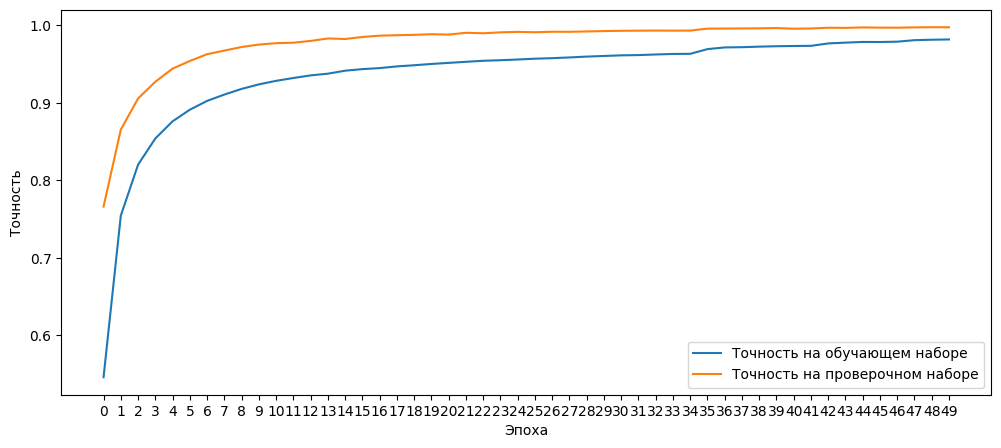

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Загрузка предобученной модели
#url_model = 'https://drive.google.com/uc?id=1n51D2Uh1lJ-TPKHrmhXmCUnonZnNH0kh'
#file_model = 'model_conv_audio.h5'
#gdown.download(url_model, file_model, quiet=True)
#model = load_model(file_model)

# Обучение сверточной модели с сохранением лучшего результата через колбэки
model = create_train_classifier(x_train.shape[1:])

# Скачивание лучшей модели
files.download('/content/model_conv_audio.h5')

#gc.collect() # почистим память

In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

4361/4361 [==============================] - 20s 5ms/step - loss: 0.0078 - accuracy: 0.9974
Ошибка: 0.007813825272023678, точность: 0.9973626732826233
4361/4361 [==============================] - 14s 3ms/step


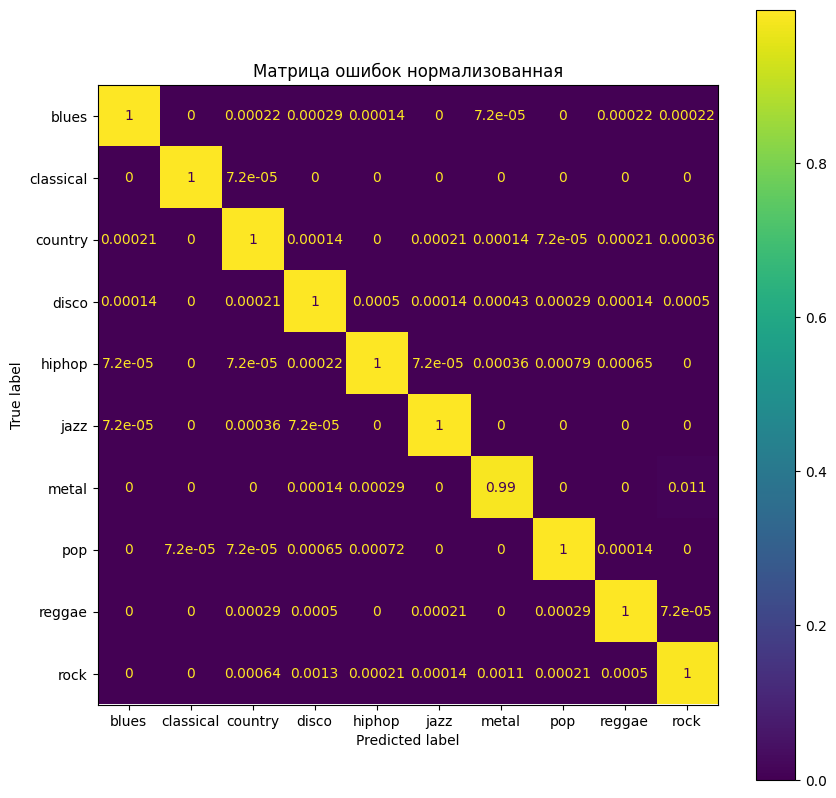

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_val, y_val)

4038/4038 [==============================] - 19s 5ms/step - loss: 4.8505 - accuracy: 0.4880
Ошибка: 4.850500583648682, точность: 0.4879798889160156
4038/4038 [==============================] - 15s 4ms/step


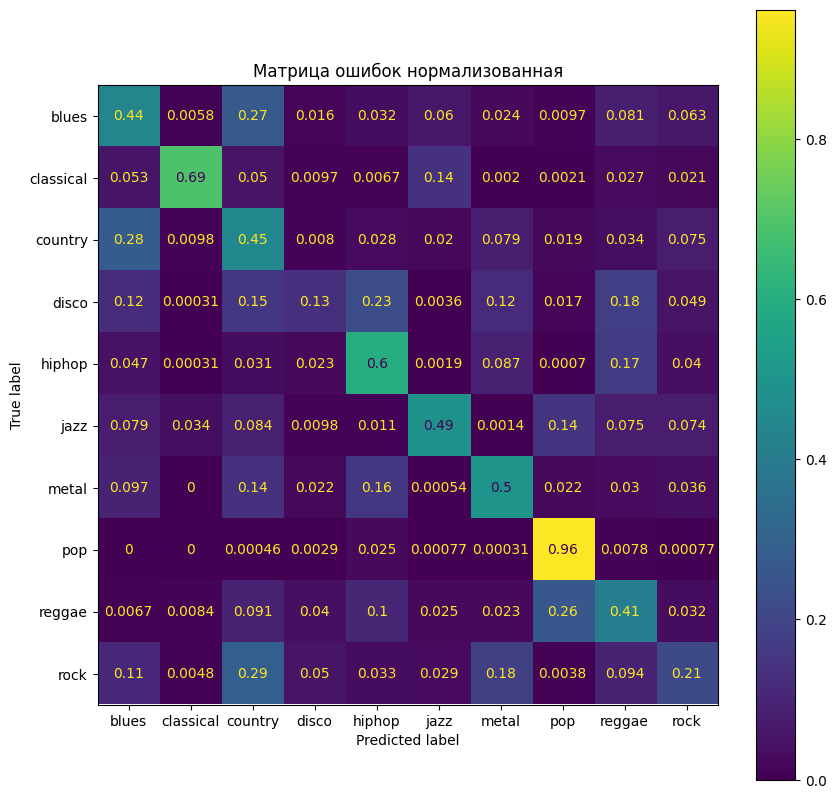

In [ ]:
# Нормирование признаков тестового набора в соответствии со стандартным нормальным распределением
x_test = x_scaler.fit_transform(x_test)
# Оценка точности сети на тестовой выборке
eval_model(model, x_test, y_test)

Файл: ./genres/blues/blues.00080.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 9ms/step
Классификация сети: blues - ВЕРНО :-)


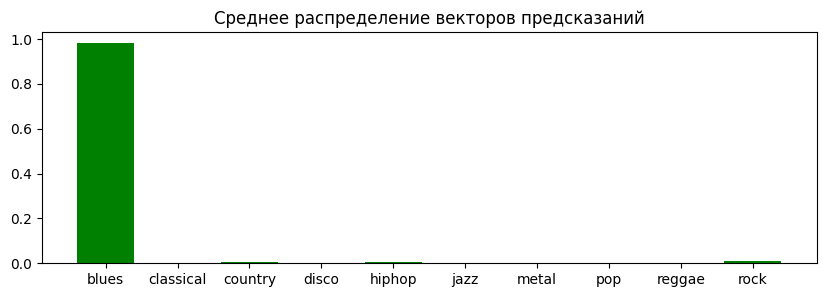

---------------------------------------------------------------
Файл: ./genres/blues/blues.00081.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - ВЕРНО :-)


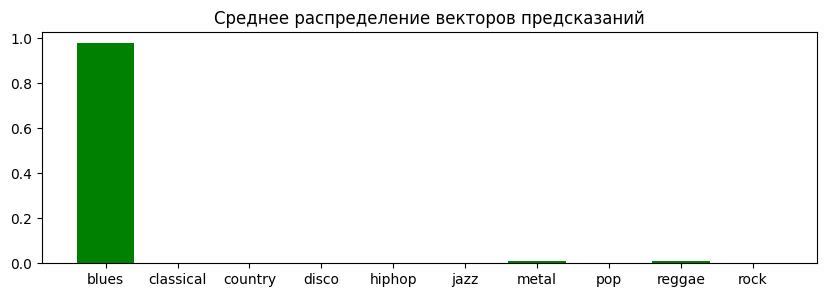

---------------------------------------------------------------
Файл: ./genres/blues/blues.00082.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: blues - ВЕРНО :-)


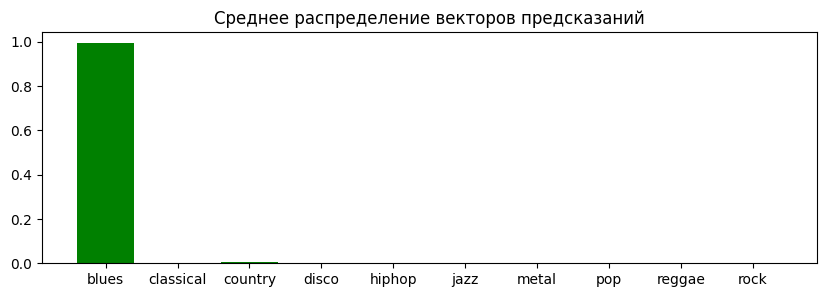

---------------------------------------------------------------
Файл: ./genres/blues/blues.00083.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - ВЕРНО :-)


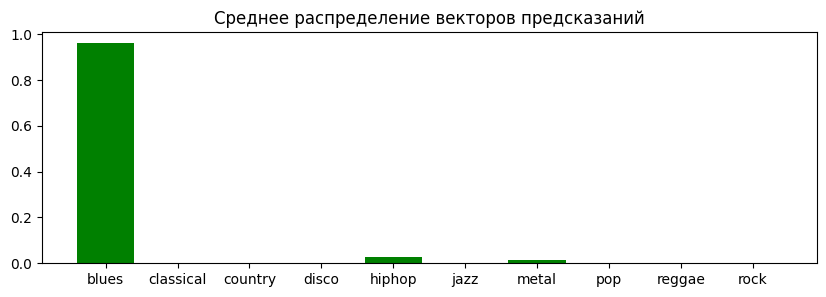

---------------------------------------------------------------
Файл: ./genres/blues/blues.00084.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - ВЕРНО :-)


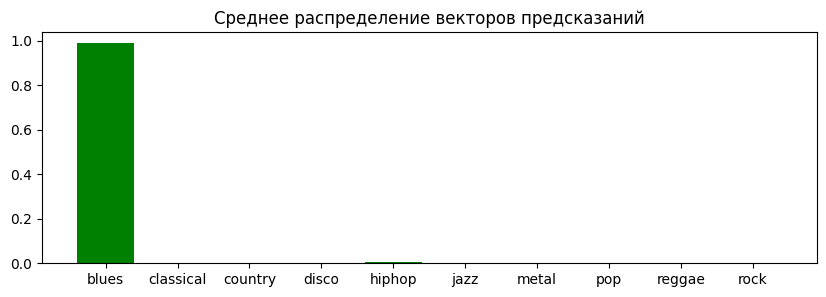

---------------------------------------------------------------
Файл: ./genres/blues/blues.00085.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: blues - ВЕРНО :-)


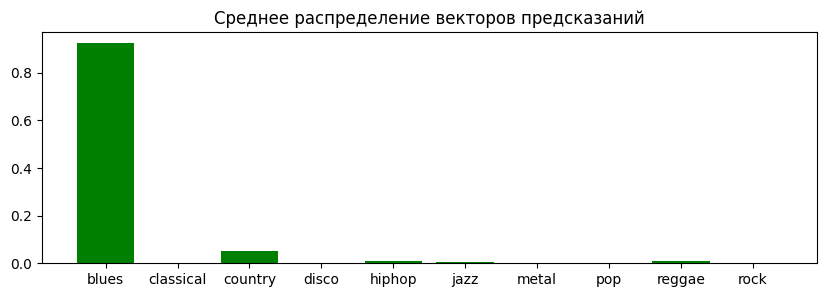

---------------------------------------------------------------
Файл: ./genres/blues/blues.00086.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - ВЕРНО :-)


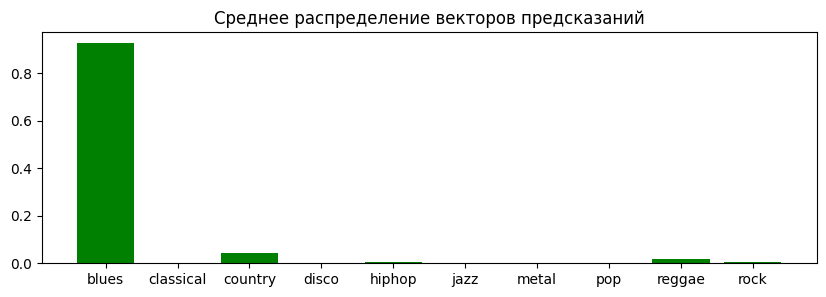

---------------------------------------------------------------
Файл: ./genres/classical/classical.00080.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: classical - ВЕРНО :-)


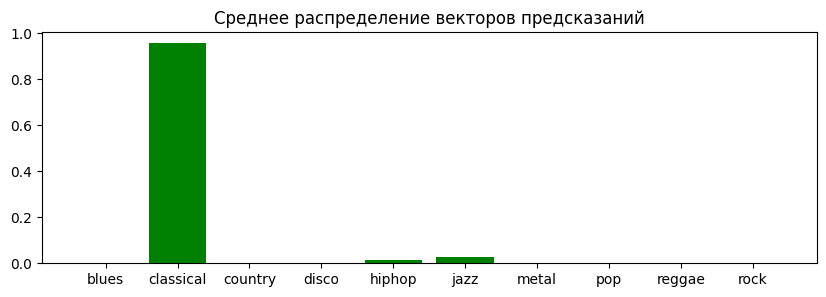

---------------------------------------------------------------
Файл: ./genres/classical/classical.00081.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: classical - ВЕРНО :-)


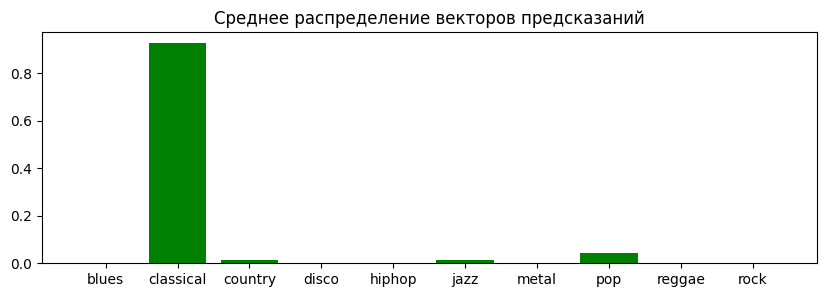

---------------------------------------------------------------
Файл: ./genres/classical/classical.00082.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: classical - ВЕРНО :-)


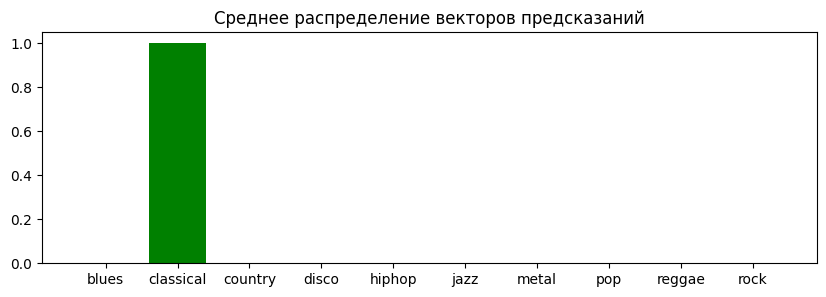

---------------------------------------------------------------
Файл: ./genres/classical/classical.00083.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: classical - ВЕРНО :-)


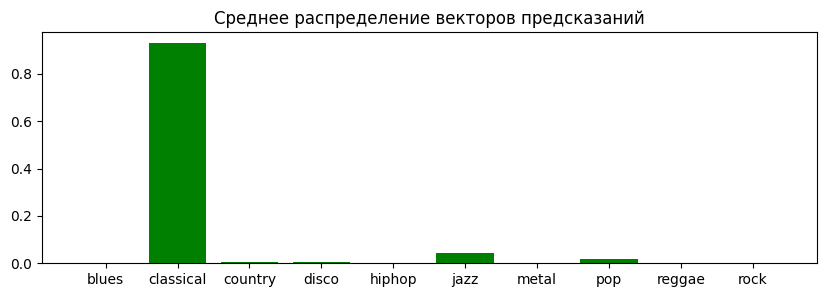

---------------------------------------------------------------
Файл: ./genres/classical/classical.00084.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: classical - ВЕРНО :-)


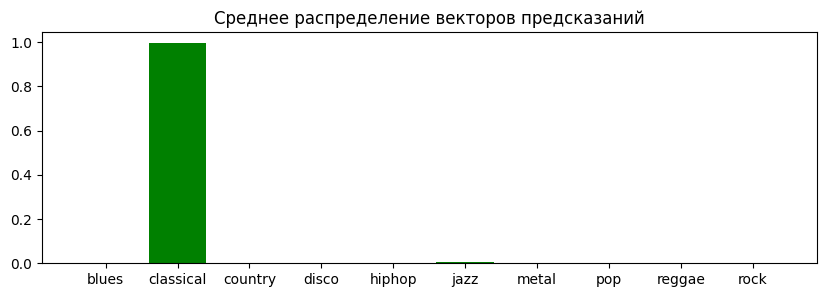

---------------------------------------------------------------
Файл: ./genres/classical/classical.00085.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: classical - ВЕРНО :-)


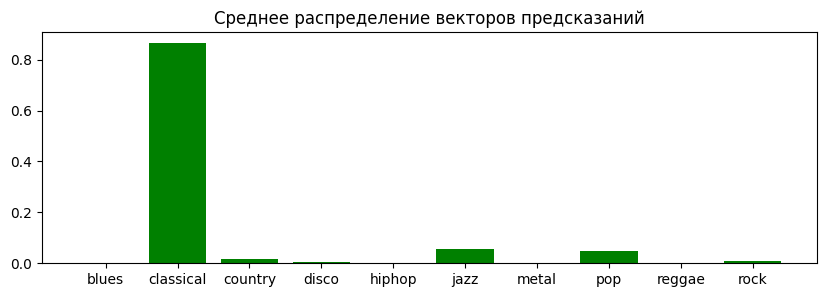

---------------------------------------------------------------
Файл: ./genres/classical/classical.00086.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: classical - ВЕРНО :-)


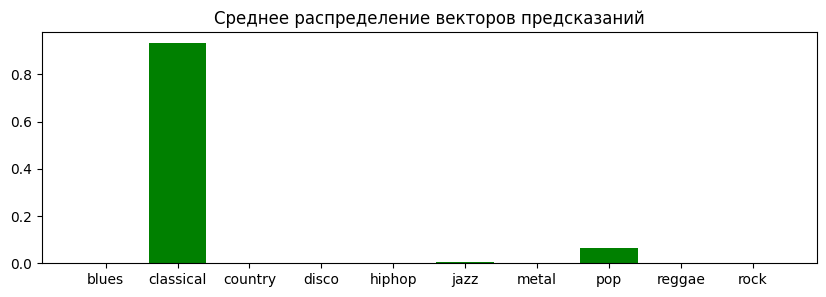

---------------------------------------------------------------
Файл: ./genres/country/country.00080.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: country - ВЕРНО :-)


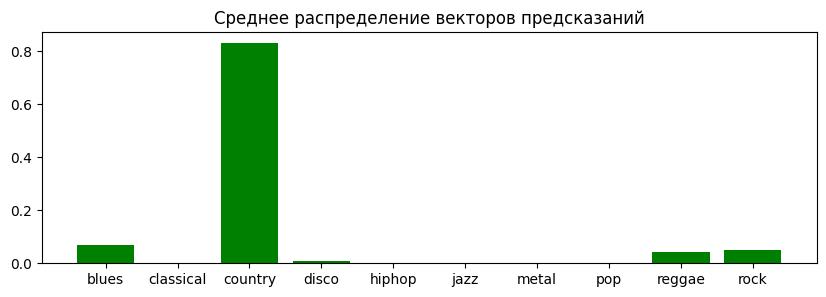

---------------------------------------------------------------
Файл: ./genres/country/country.00081.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: country - ВЕРНО :-)


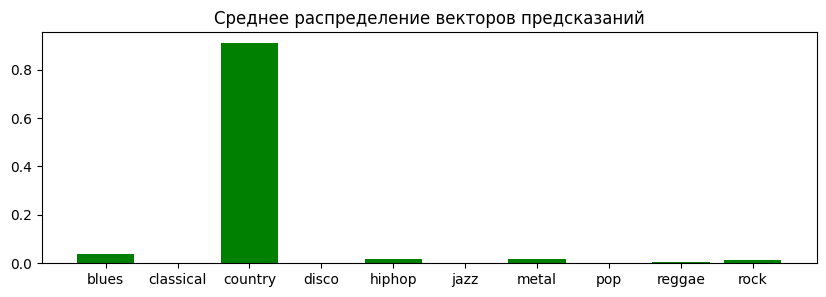

---------------------------------------------------------------
Файл: ./genres/country/country.00082.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: country - ВЕРНО :-)


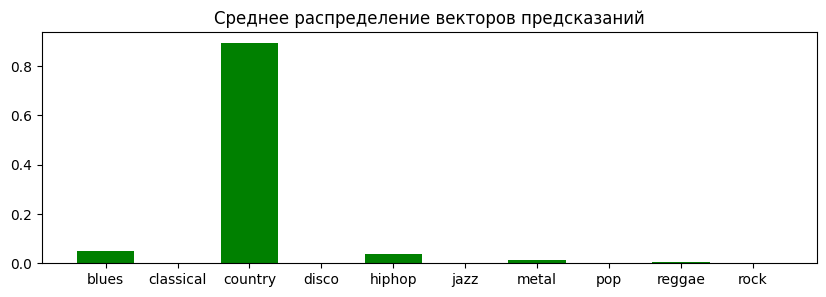

---------------------------------------------------------------
Файл: ./genres/country/country.00083.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: country - ВЕРНО :-)


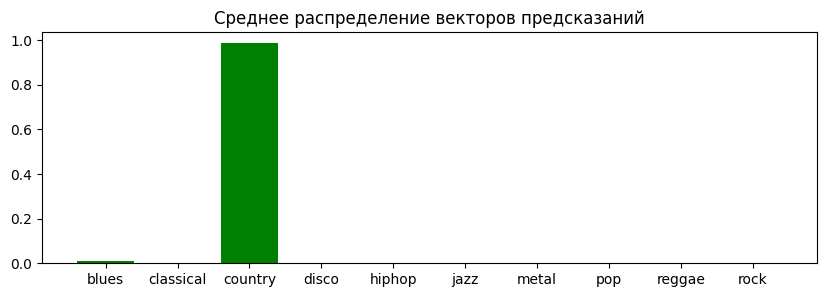

---------------------------------------------------------------
Файл: ./genres/country/country.00084.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: country - ВЕРНО :-)


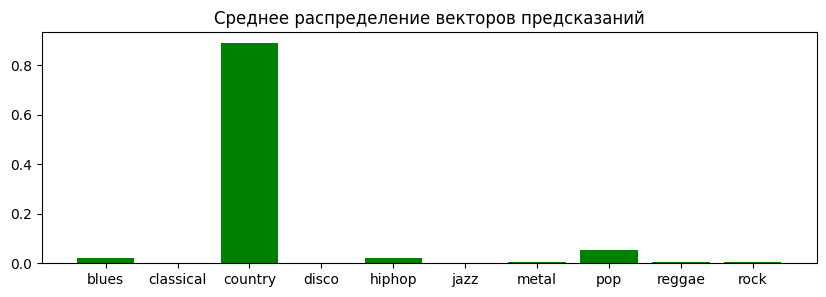

---------------------------------------------------------------
Файл: ./genres/country/country.00085.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: country - ВЕРНО :-)


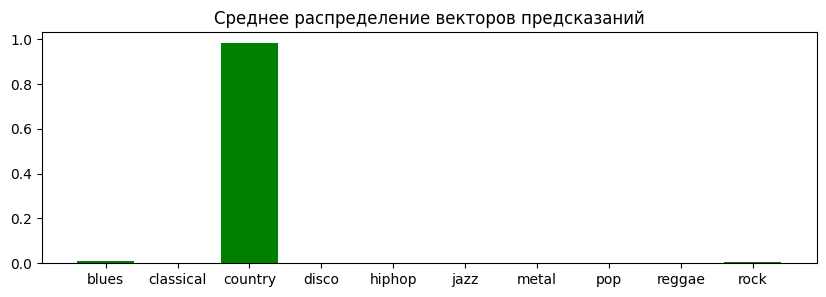

---------------------------------------------------------------
Файл: ./genres/country/country.00086.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: country - ВЕРНО :-)


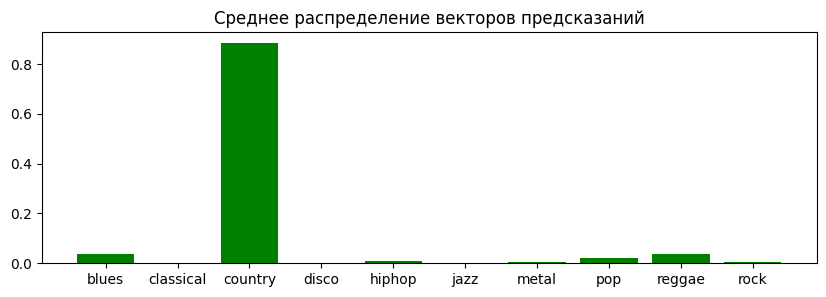

---------------------------------------------------------------
Файл: ./genres/disco/disco.00080.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: disco - ВЕРНО :-)


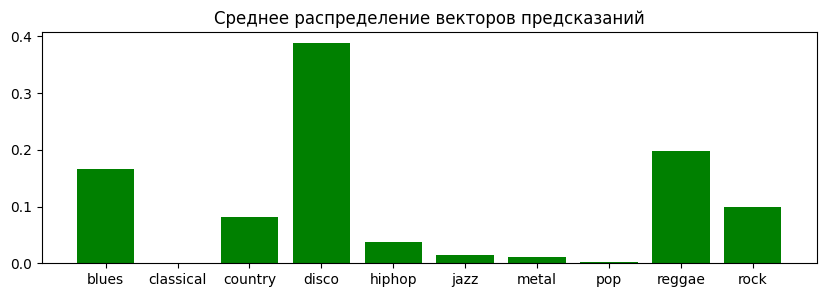

---------------------------------------------------------------
Файл: ./genres/disco/disco.00081.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: disco - ВЕРНО :-)


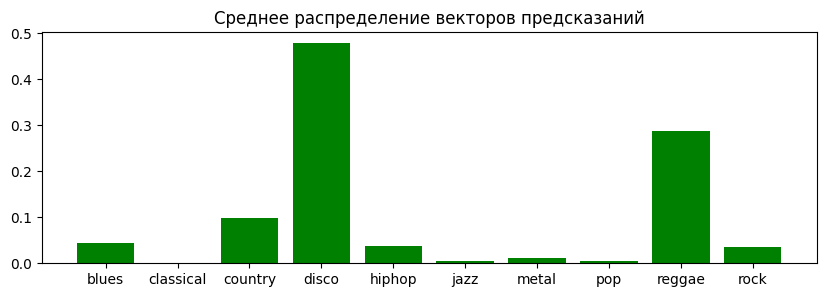

---------------------------------------------------------------
Файл: ./genres/disco/disco.00082.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 6ms/step
Классификация сети: disco - ВЕРНО :-)


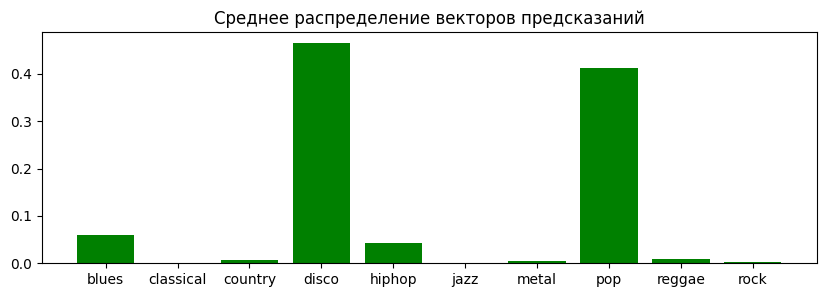

---------------------------------------------------------------
Файл: ./genres/disco/disco.00083.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: disco - ВЕРНО :-)


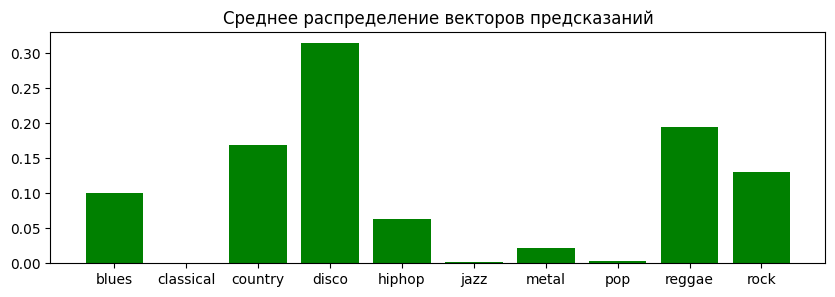

---------------------------------------------------------------
Файл: ./genres/disco/disco.00084.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: disco - ВЕРНО :-)


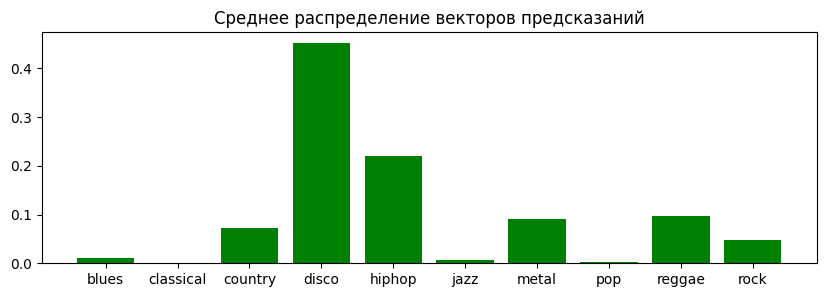

---------------------------------------------------------------
Файл: ./genres/disco/disco.00085.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: hiphop - НЕВЕРНО.


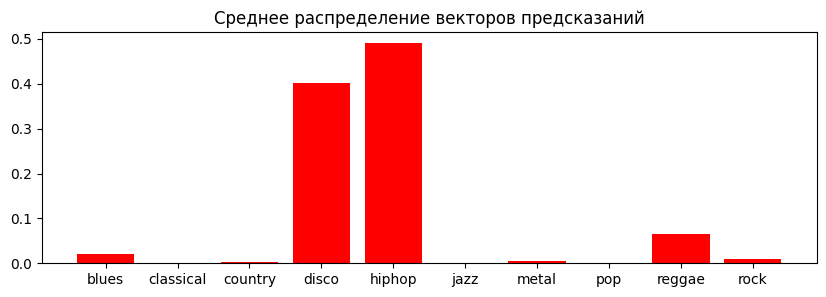

---------------------------------------------------------------
Файл: ./genres/disco/disco.00086.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: disco - ВЕРНО :-)


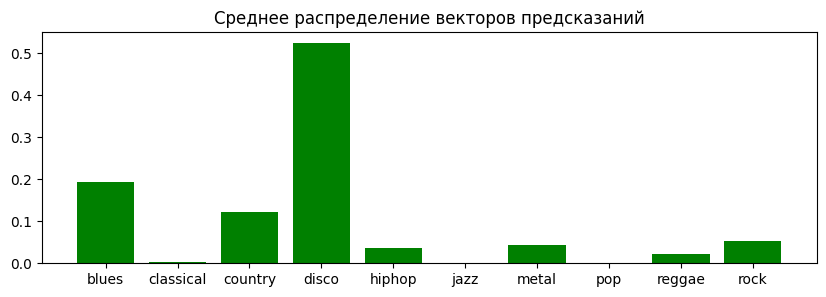

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00080.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: hiphop - ВЕРНО :-)


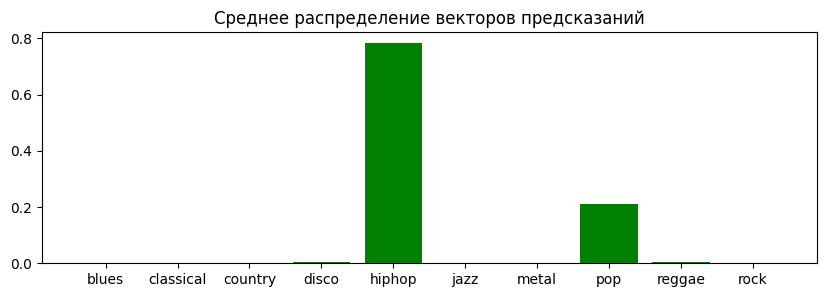

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00081.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: hiphop - ВЕРНО :-)


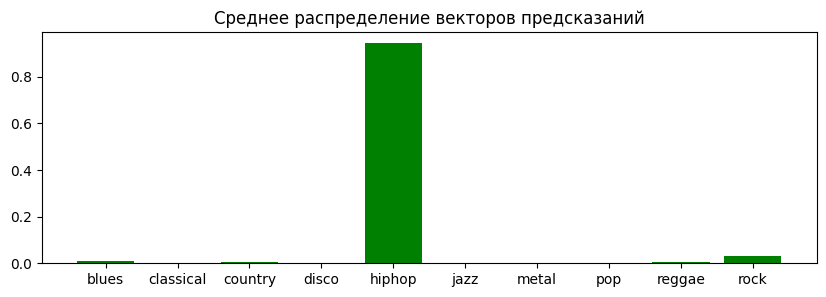

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00082.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: hiphop - ВЕРНО :-)


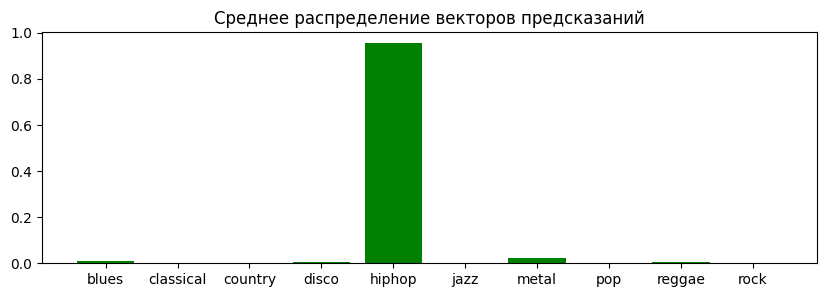

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00083.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: hiphop - ВЕРНО :-)


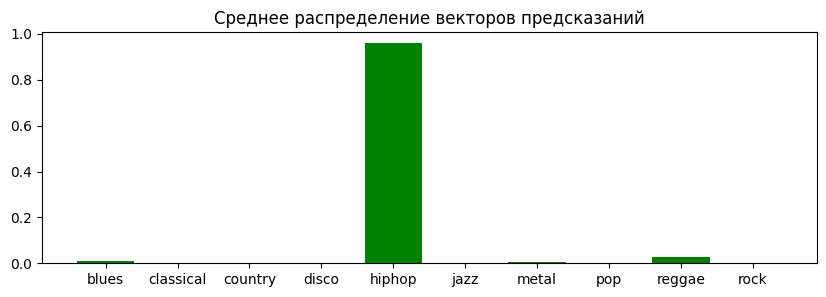

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00084.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: hiphop - ВЕРНО :-)


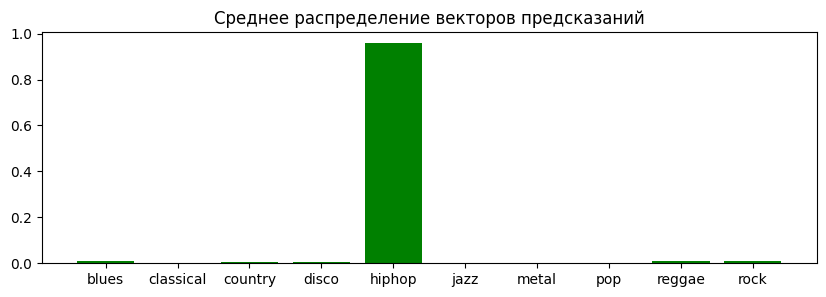

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00085.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: hiphop - ВЕРНО :-)


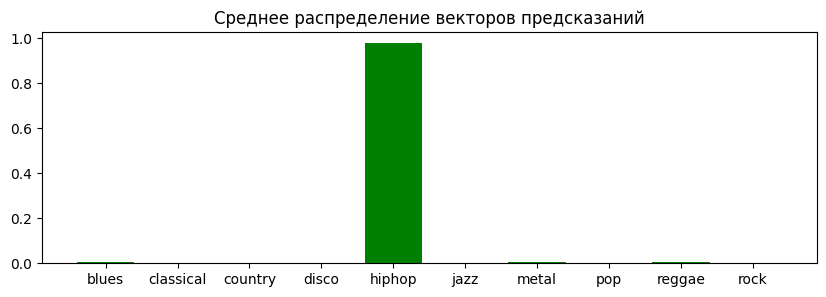

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00086.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: hiphop - ВЕРНО :-)


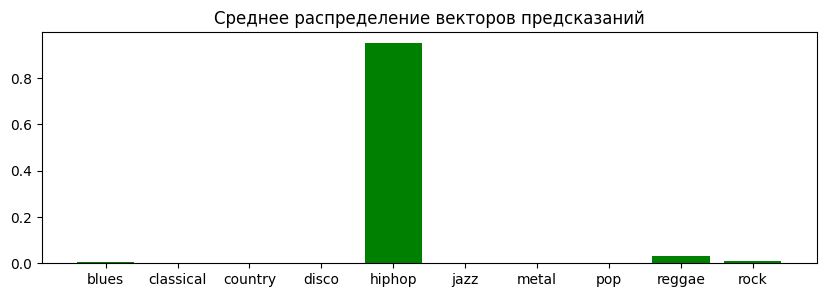

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00080.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: jazz - ВЕРНО :-)


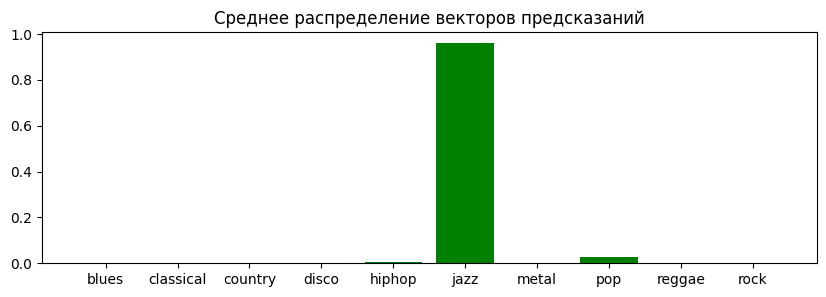

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00081.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: jazz - ВЕРНО :-)


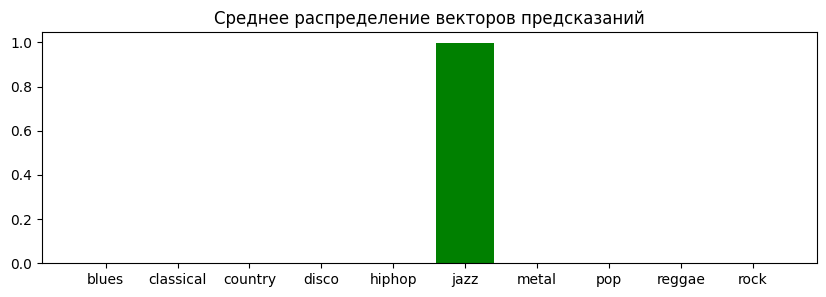

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00082.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: jazz - ВЕРНО :-)


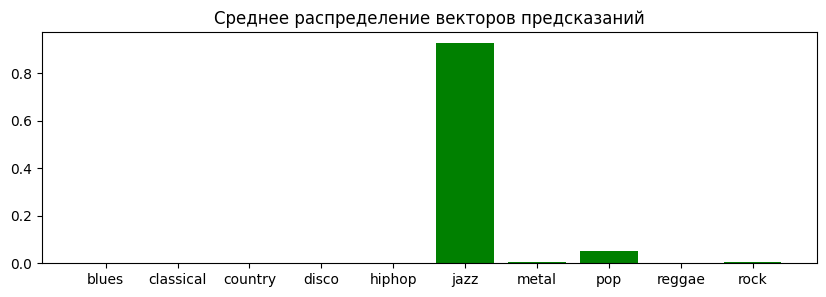

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00083.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: jazz - ВЕРНО :-)


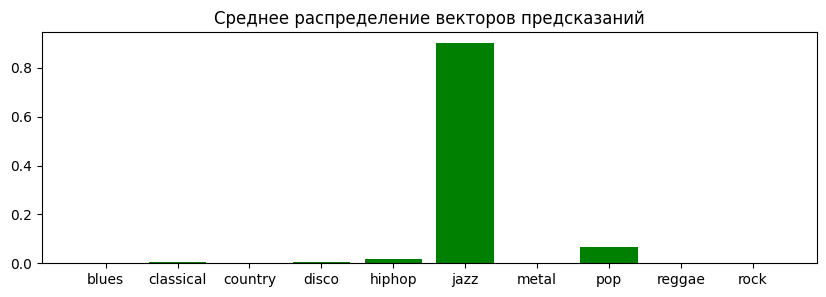

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00084.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: jazz - ВЕРНО :-)


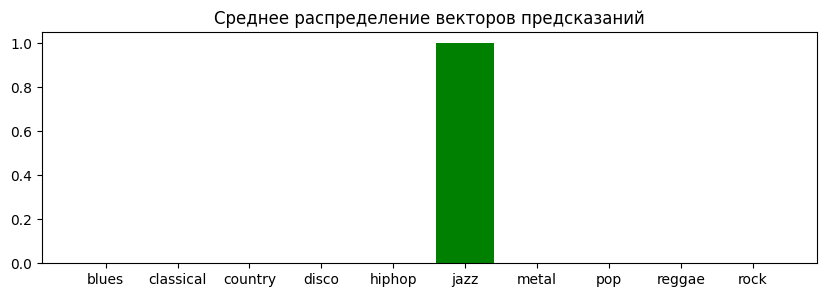

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00085.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: jazz - ВЕРНО :-)


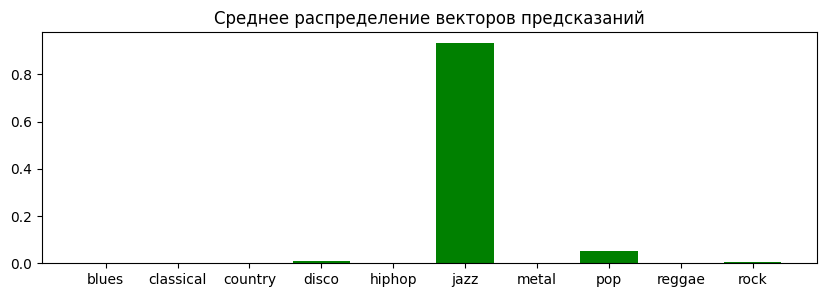

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00086.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: jazz - ВЕРНО :-)


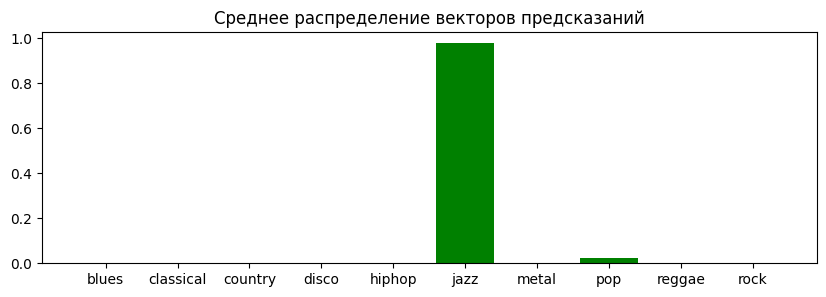

---------------------------------------------------------------
Файл: ./genres/metal/metal.00080.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: metal - ВЕРНО :-)


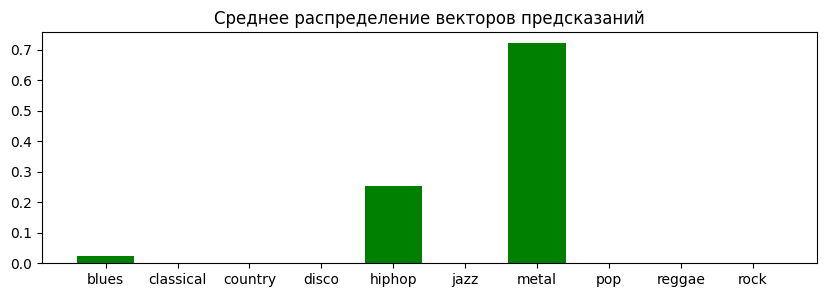

---------------------------------------------------------------
Файл: ./genres/metal/metal.00081.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: metal - ВЕРНО :-)


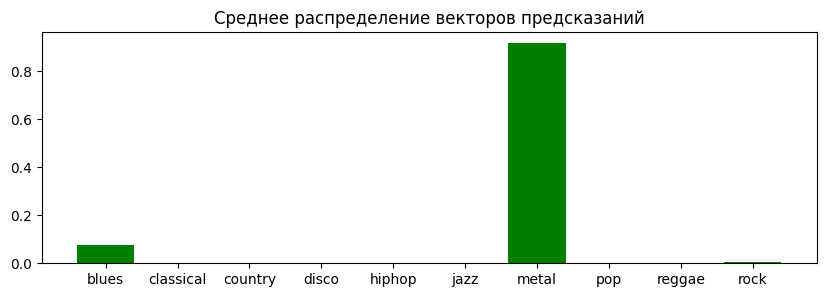

---------------------------------------------------------------
Файл: ./genres/metal/metal.00082.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: metal - ВЕРНО :-)


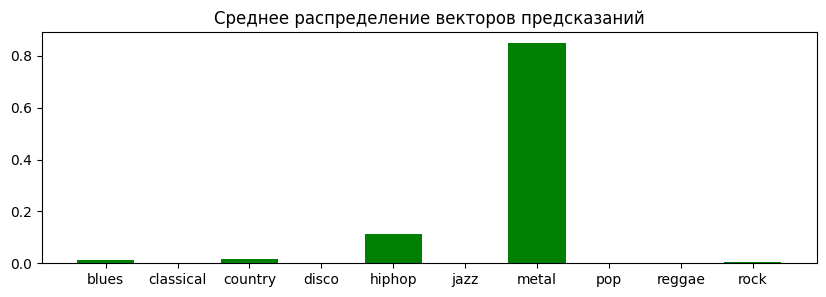

---------------------------------------------------------------
Файл: ./genres/metal/metal.00083.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: metal - ВЕРНО :-)


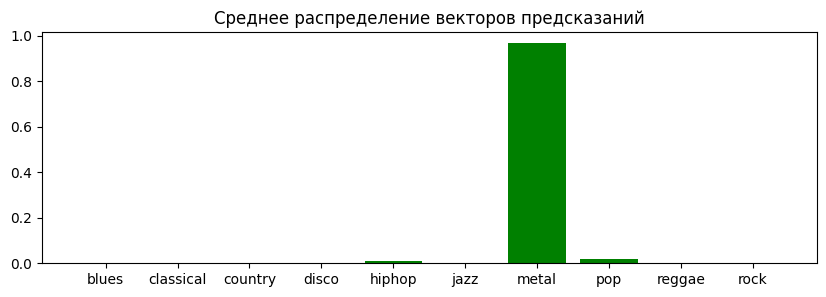

---------------------------------------------------------------
Файл: ./genres/metal/metal.00084.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 6ms/step
Классификация сети: metal - ВЕРНО :-)


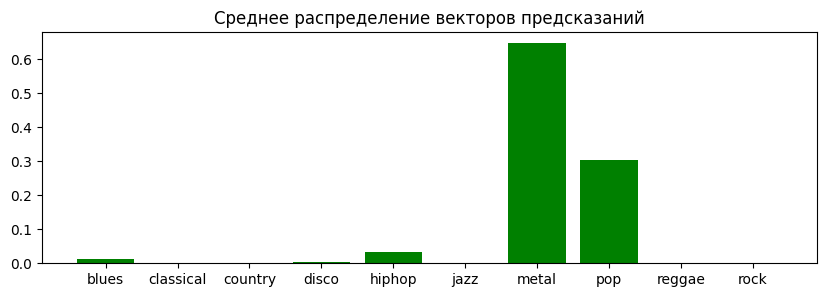

---------------------------------------------------------------
Файл: ./genres/metal/metal.00085.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 8ms/step
Классификация сети: metal - ВЕРНО :-)


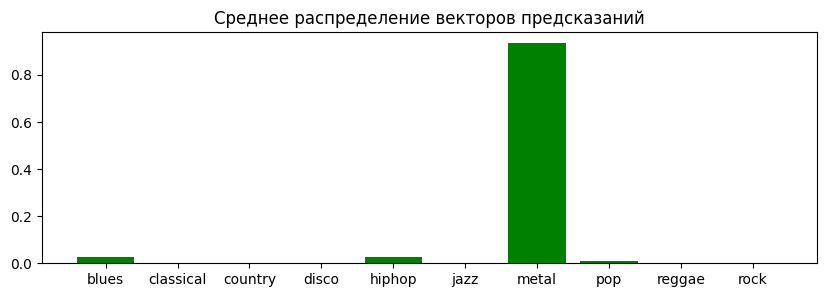

---------------------------------------------------------------
Файл: ./genres/metal/metal.00086.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: metal - ВЕРНО :-)


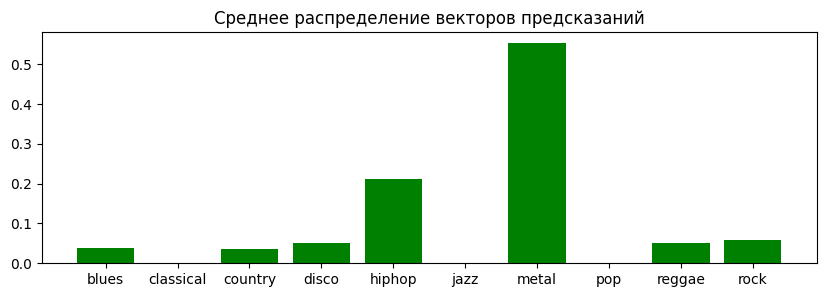

---------------------------------------------------------------
Файл: ./genres/pop/pop.00080.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: pop - ВЕРНО :-)


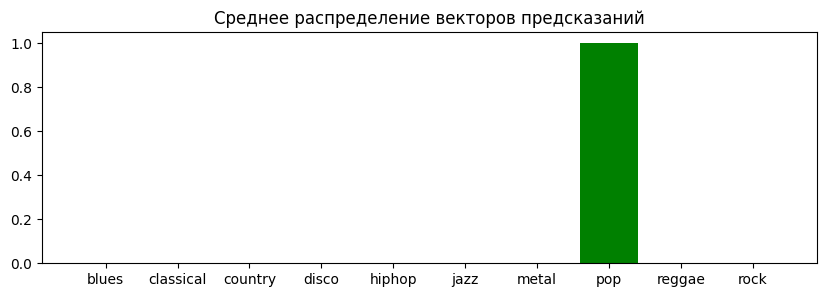

---------------------------------------------------------------
Файл: ./genres/pop/pop.00081.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - ВЕРНО :-)


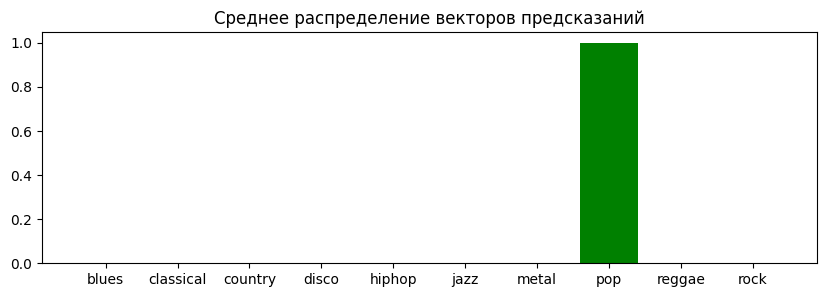

---------------------------------------------------------------
Файл: ./genres/pop/pop.00082.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - ВЕРНО :-)


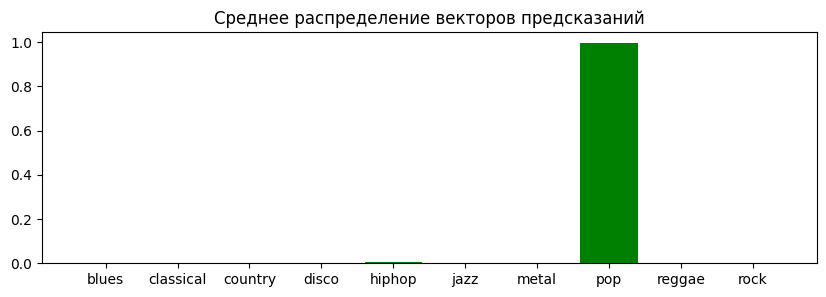

---------------------------------------------------------------
Файл: ./genres/pop/pop.00083.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - ВЕРНО :-)


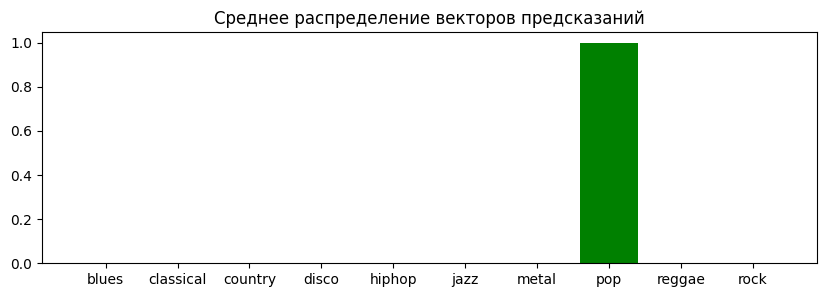

---------------------------------------------------------------
Файл: ./genres/pop/pop.00084.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - ВЕРНО :-)


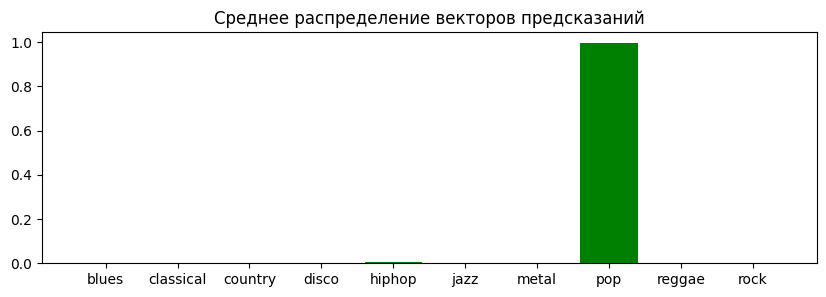

---------------------------------------------------------------
Файл: ./genres/pop/pop.00085.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: pop - ВЕРНО :-)


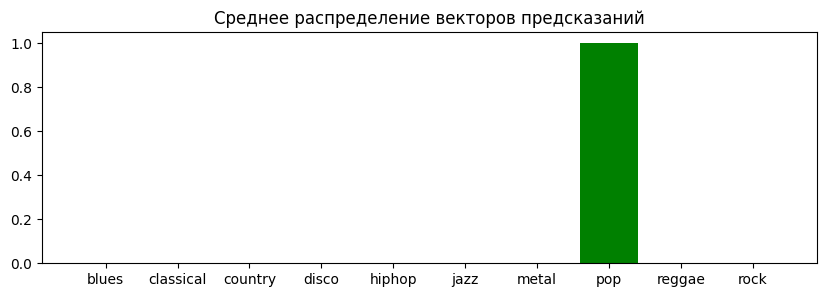

---------------------------------------------------------------
Файл: ./genres/pop/pop.00086.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 6ms/step
Классификация сети: pop - ВЕРНО :-)


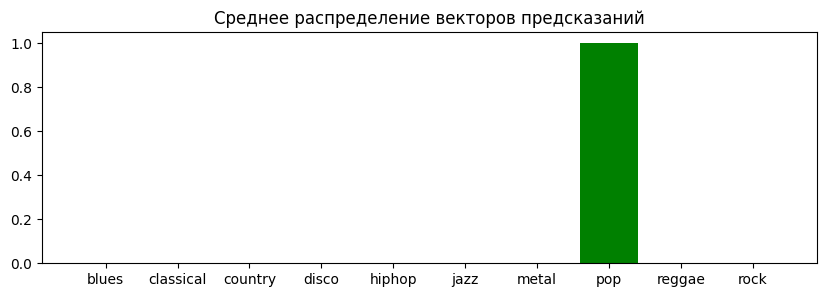

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00080.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: reggae - ВЕРНО :-)


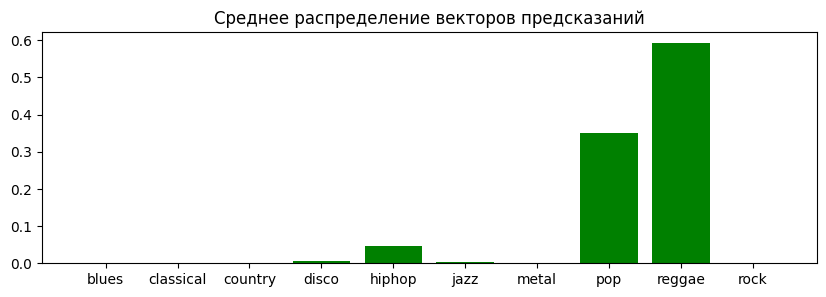

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00081.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: reggae - ВЕРНО :-)


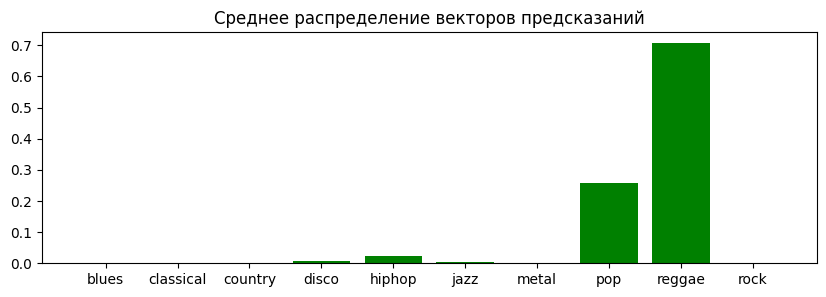

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00082.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 6ms/step
Классификация сети: reggae - ВЕРНО :-)


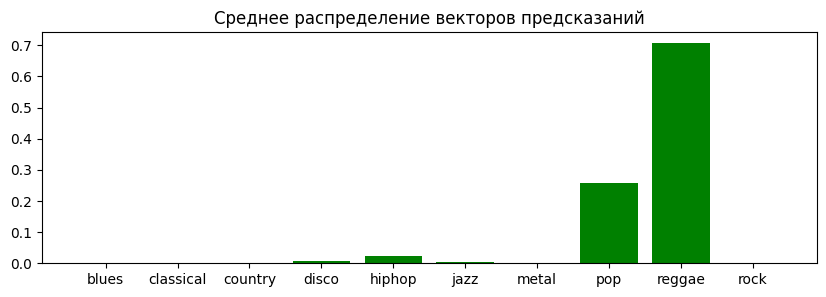

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00083.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: reggae - ВЕРНО :-)


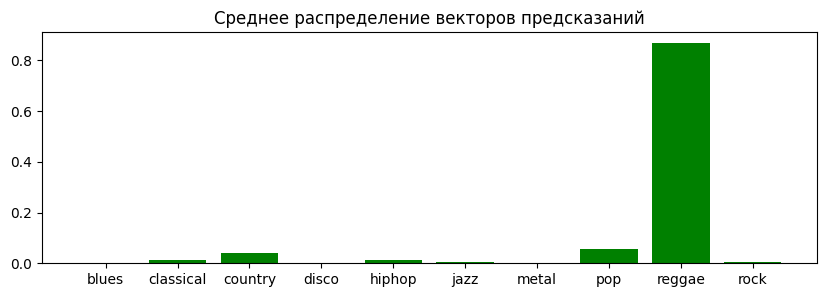

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00084.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: reggae - ВЕРНО :-)


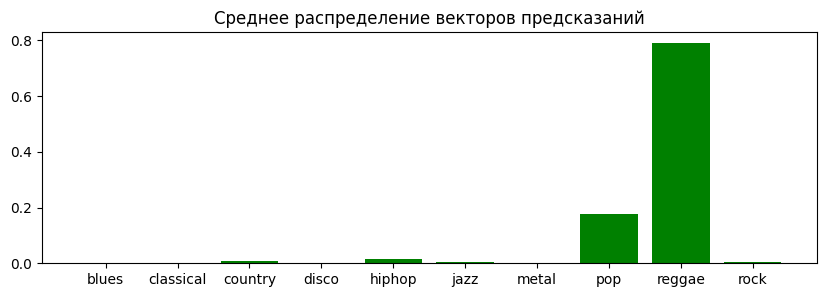

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00085.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 6ms/step
Классификация сети: reggae - ВЕРНО :-)


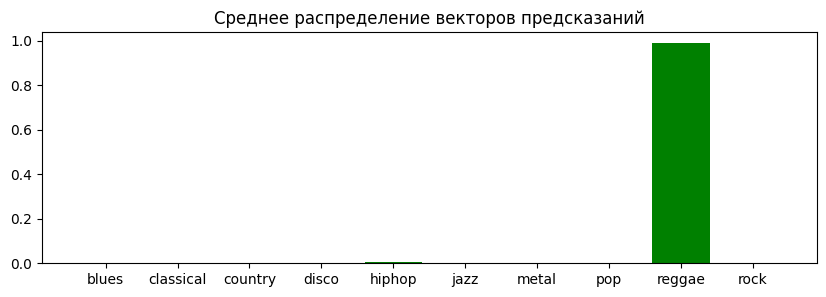

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00086.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - НЕВЕРНО.


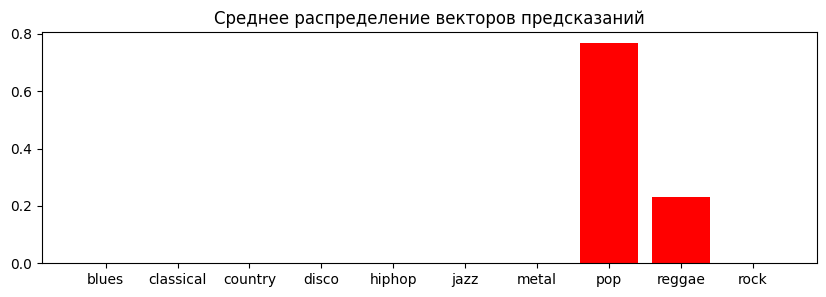

---------------------------------------------------------------
Файл: ./genres/rock/rock.00080.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: rock - ВЕРНО :-)


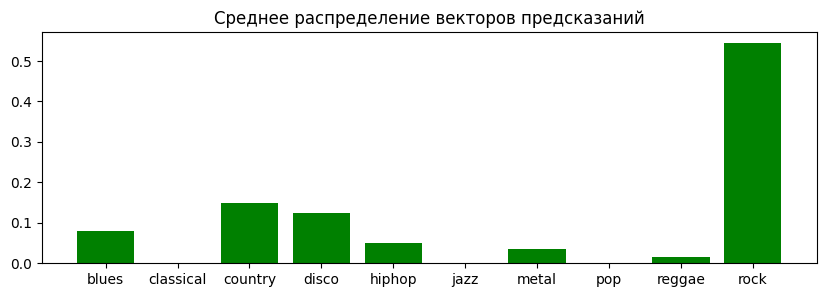

---------------------------------------------------------------
Файл: ./genres/rock/rock.00081.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: rock - ВЕРНО :-)


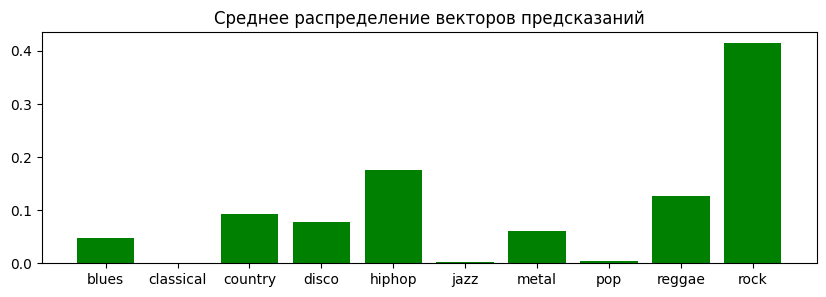

---------------------------------------------------------------
Файл: ./genres/rock/rock.00082.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: rock - ВЕРНО :-)


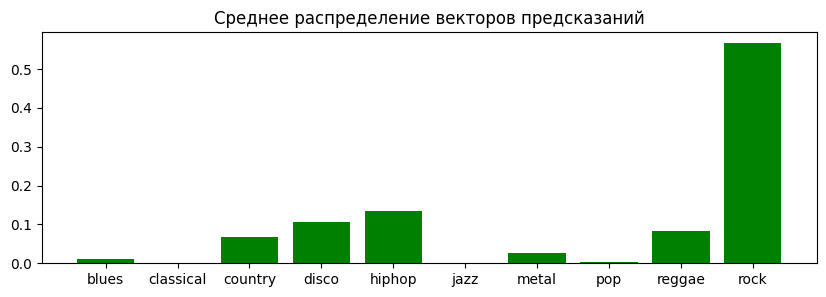

---------------------------------------------------------------
Файл: ./genres/rock/rock.00083.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: country - НЕВЕРНО.


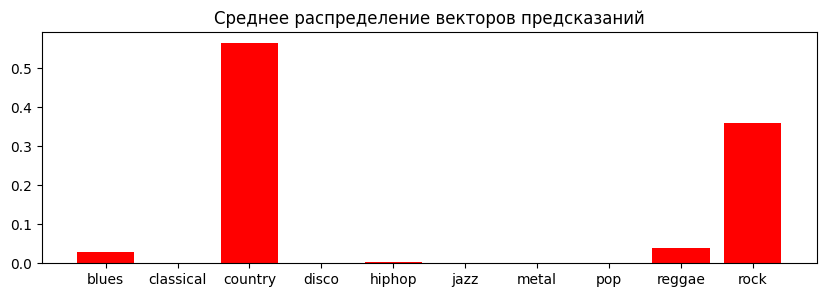

---------------------------------------------------------------
Файл: ./genres/rock/rock.00084.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: rock - ВЕРНО :-)


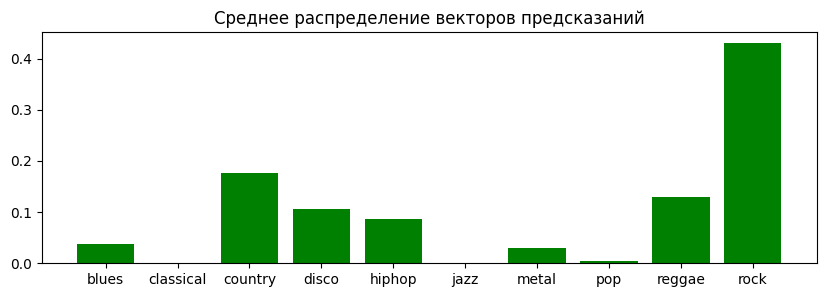

---------------------------------------------------------------
Файл: ./genres/rock/rock.00085.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: rock - ВЕРНО :-)


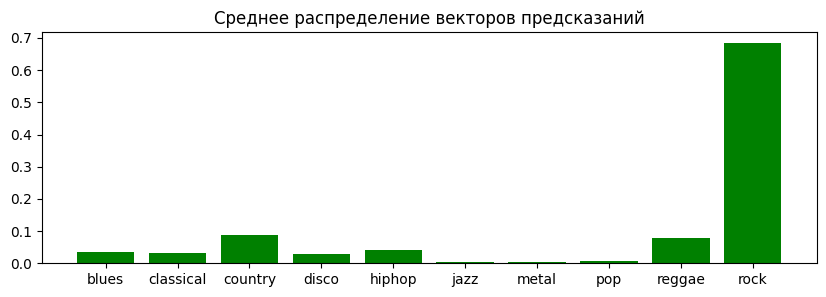

---------------------------------------------------------------
Файл: ./genres/rock/rock.00086.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: rock - ВЕРНО :-)


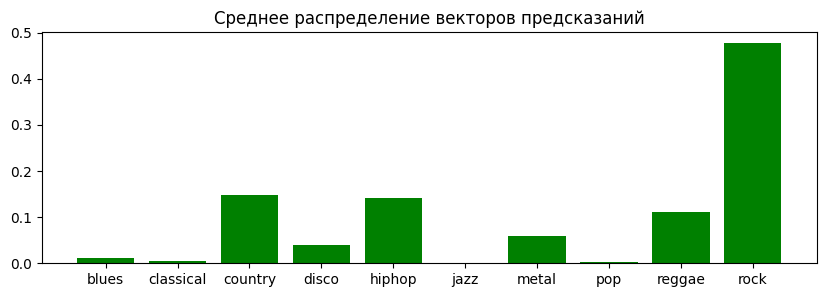

---------------------------------------------------------------
=== Обработано образцов: 70, из них распознано верно: 67, доля верных: 95.71% ===


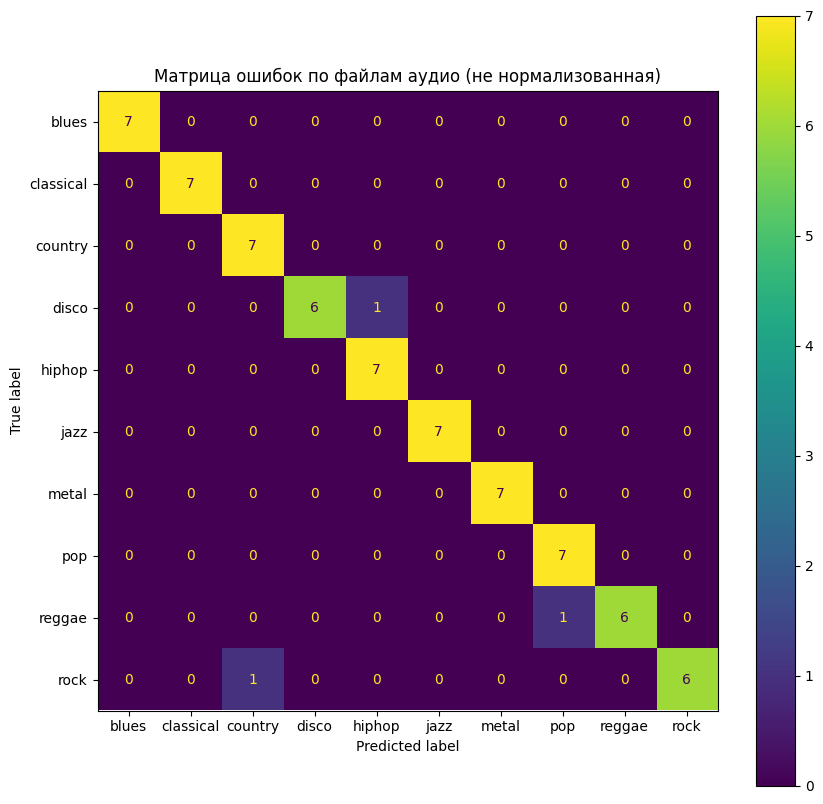

In [ ]:
# Визуализация классификации файлов из проверочного набора
classify_test_files(model, x_scaler, 80, 7)

Файл: ./genres/blues/blues.00090.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: blues - ВЕРНО :-)


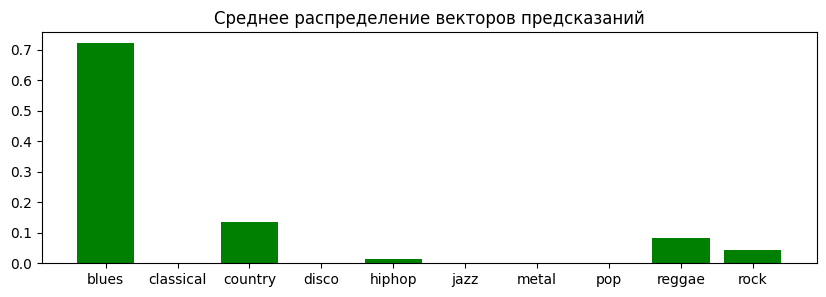

---------------------------------------------------------------
Файл: ./genres/blues/blues.00091.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: country - НЕВЕРНО.


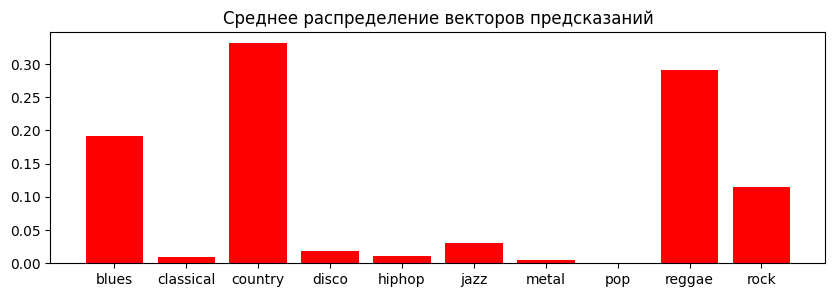

---------------------------------------------------------------
Файл: ./genres/blues/blues.00092.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - ВЕРНО :-)


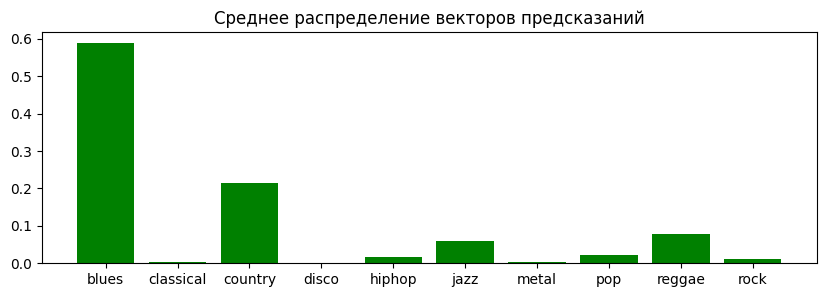

---------------------------------------------------------------
Файл: ./genres/blues/blues.00093.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: blues - ВЕРНО :-)


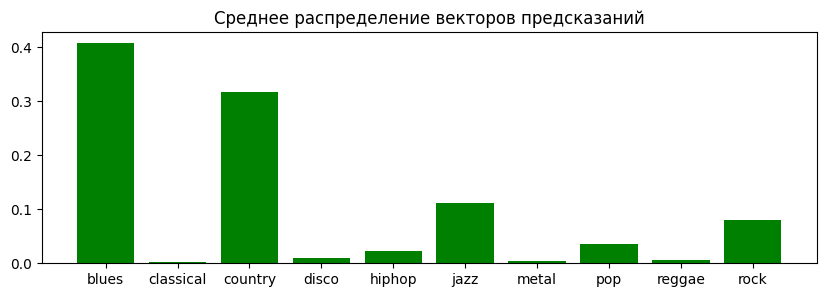

---------------------------------------------------------------
Файл: ./genres/blues/blues.00094.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - ВЕРНО :-)


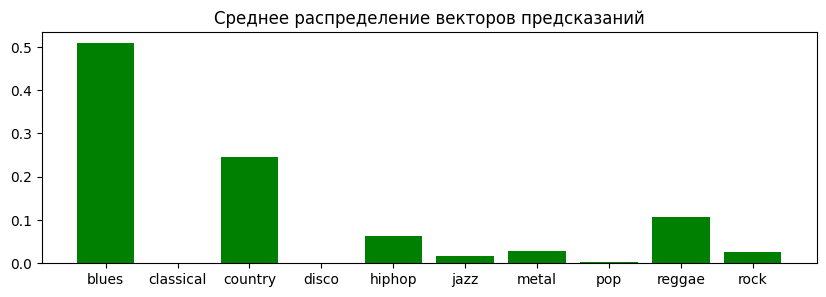

---------------------------------------------------------------
Файл: ./genres/blues/blues.00095.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - ВЕРНО :-)


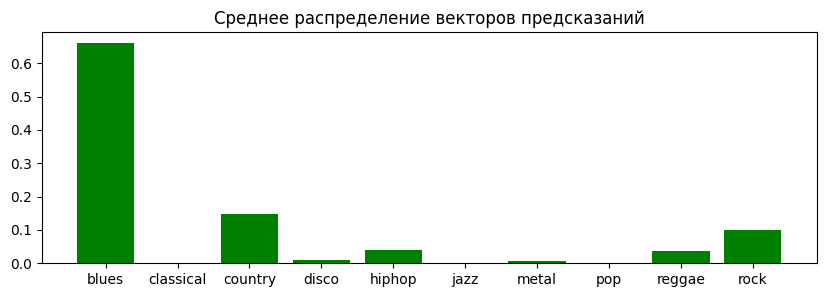

---------------------------------------------------------------
Файл: ./genres/blues/blues.00096.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: country - НЕВЕРНО.


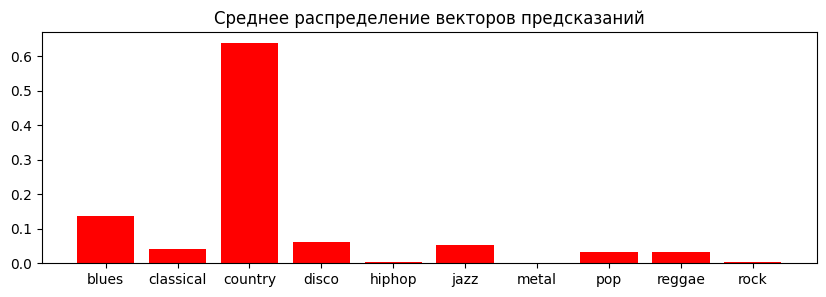

---------------------------------------------------------------
Файл: ./genres/classical/classical.00090.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: classical - ВЕРНО :-)


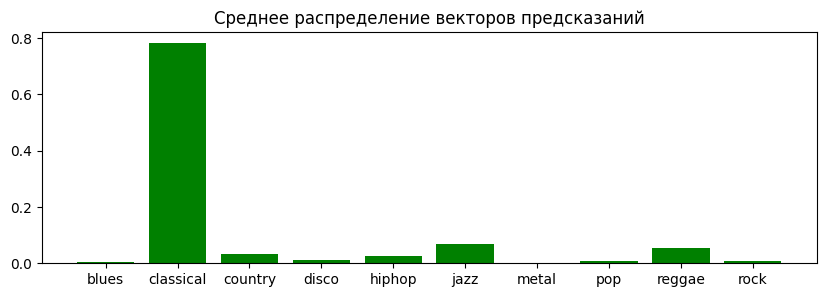

---------------------------------------------------------------
Файл: ./genres/classical/classical.00091.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: classical - ВЕРНО :-)


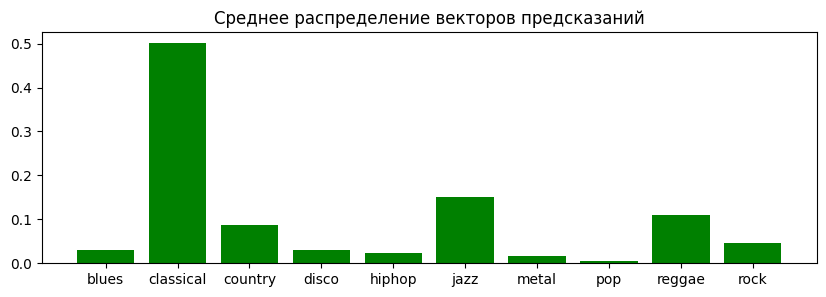

---------------------------------------------------------------
Файл: ./genres/classical/classical.00092.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: jazz - НЕВЕРНО.


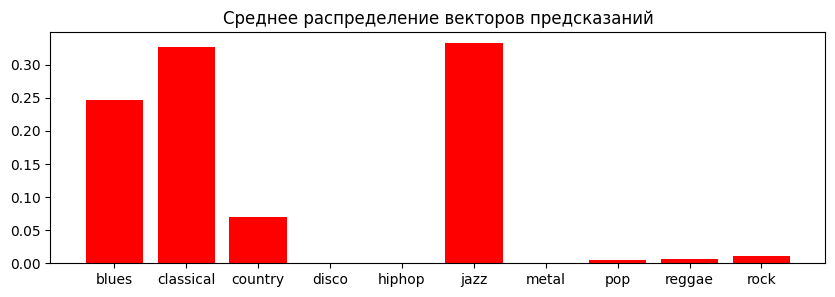

---------------------------------------------------------------
Файл: ./genres/classical/classical.00093.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: classical - ВЕРНО :-)


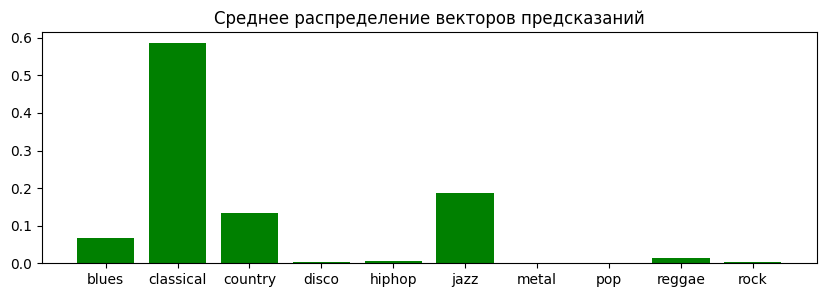

---------------------------------------------------------------
Файл: ./genres/classical/classical.00094.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: classical - ВЕРНО :-)


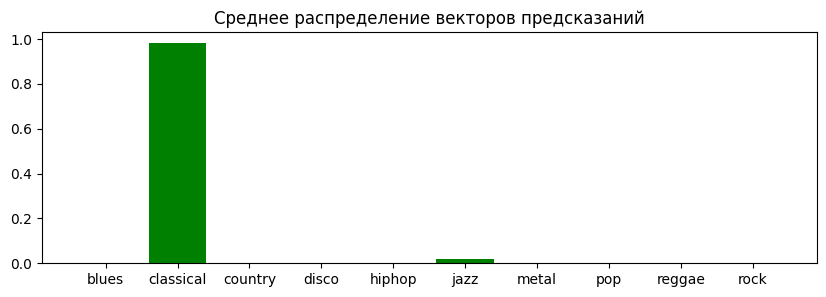

---------------------------------------------------------------
Файл: ./genres/classical/classical.00095.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: classical - ВЕРНО :-)


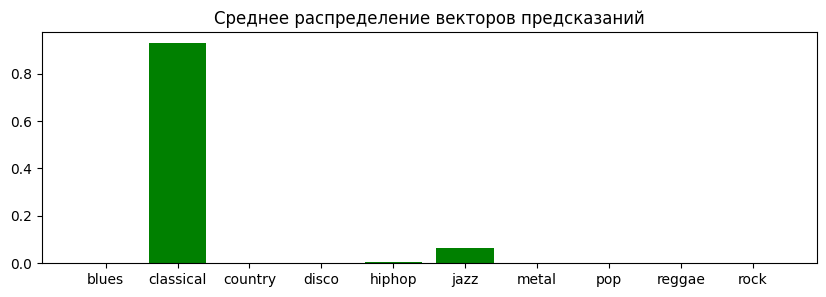

---------------------------------------------------------------
Файл: ./genres/classical/classical.00096.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: classical - ВЕРНО :-)


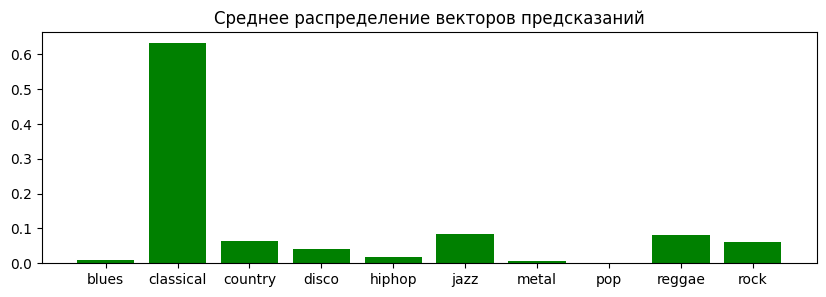

---------------------------------------------------------------
Файл: ./genres/country/country.00090.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: country - ВЕРНО :-)


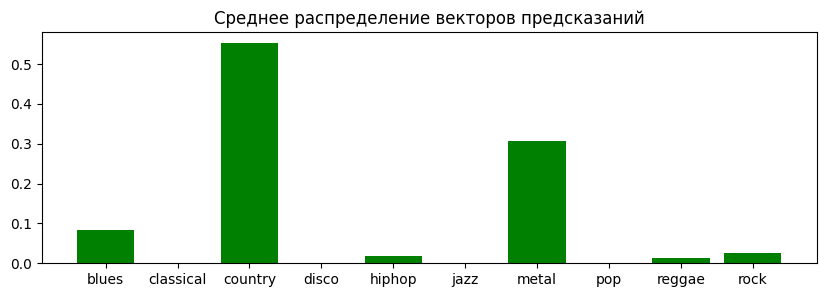

---------------------------------------------------------------
Файл: ./genres/country/country.00091.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: country - ВЕРНО :-)


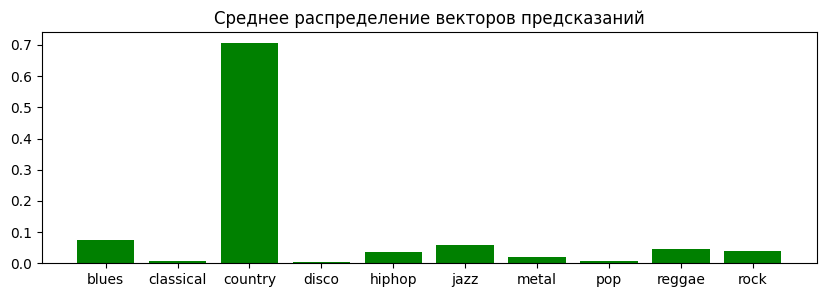

---------------------------------------------------------------
Файл: ./genres/country/country.00092.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - НЕВЕРНО.


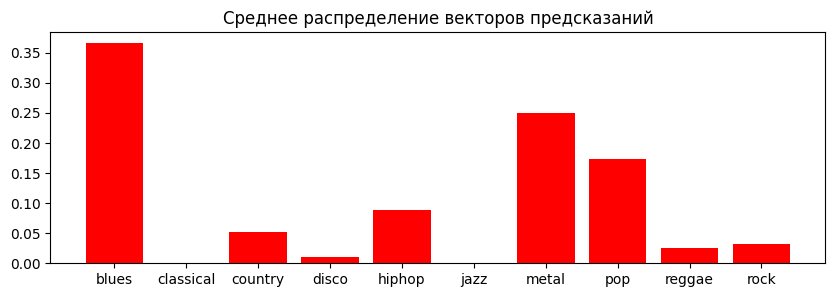

---------------------------------------------------------------
Файл: ./genres/country/country.00093.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: country - ВЕРНО :-)


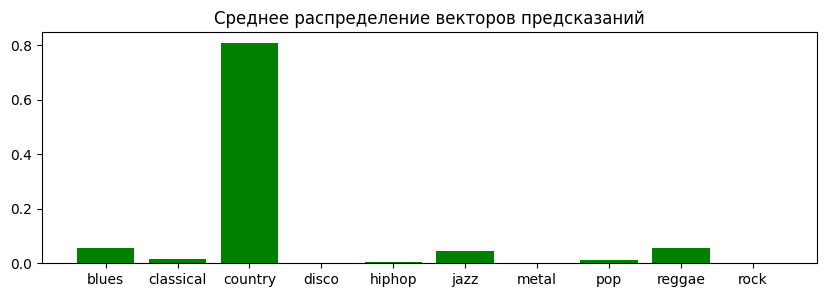

---------------------------------------------------------------
Файл: ./genres/country/country.00094.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: blues - НЕВЕРНО.


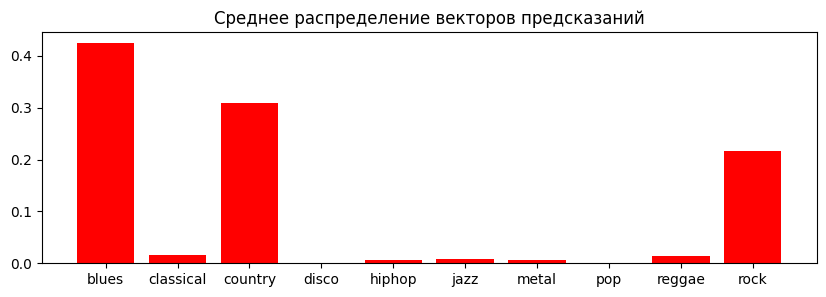

---------------------------------------------------------------
Файл: ./genres/country/country.00095.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - НЕВЕРНО.


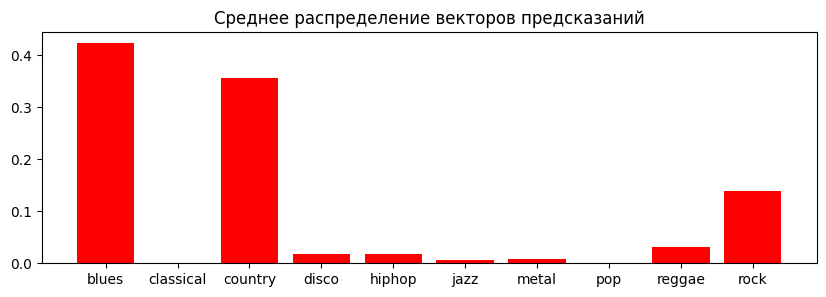

---------------------------------------------------------------
Файл: ./genres/country/country.00096.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - НЕВЕРНО.


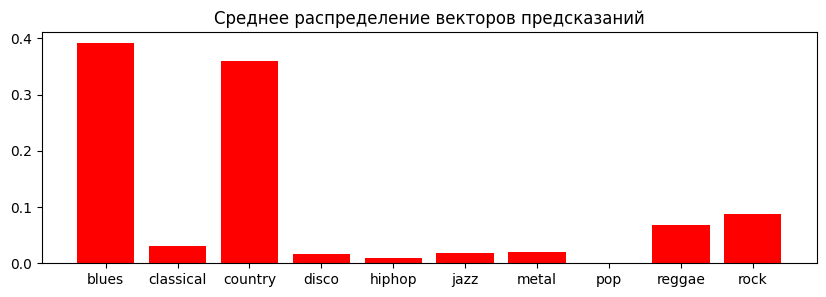

---------------------------------------------------------------
Файл: ./genres/disco/disco.00090.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: hiphop - НЕВЕРНО.


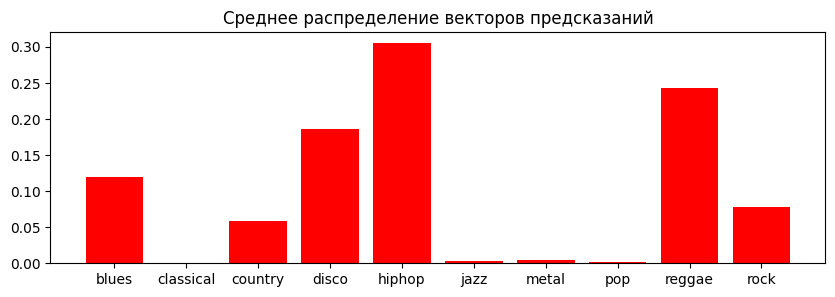

---------------------------------------------------------------
Файл: ./genres/disco/disco.00091.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: hiphop - НЕВЕРНО.


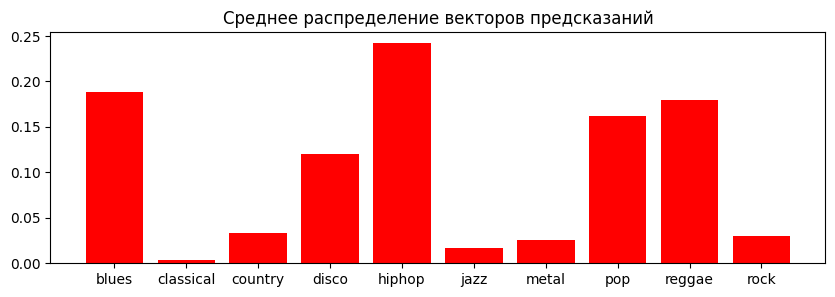

---------------------------------------------------------------
Файл: ./genres/disco/disco.00092.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: country - НЕВЕРНО.


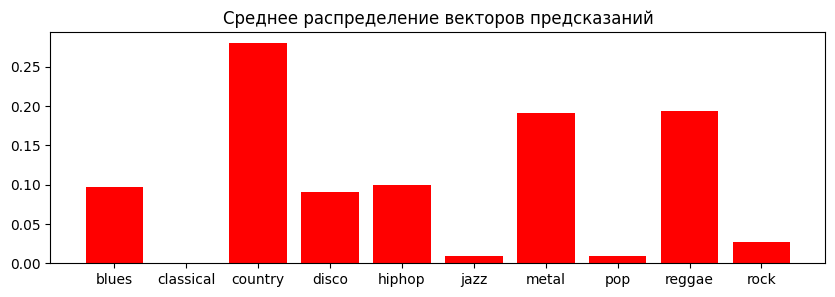

---------------------------------------------------------------
Файл: ./genres/disco/disco.00093.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: metal - НЕВЕРНО.


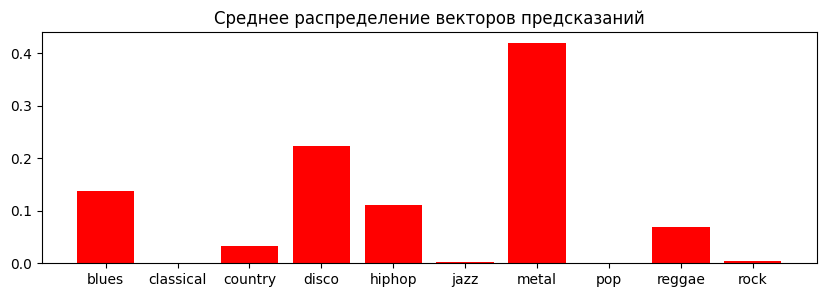

---------------------------------------------------------------
Файл: ./genres/disco/disco.00094.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: blues - НЕВЕРНО.


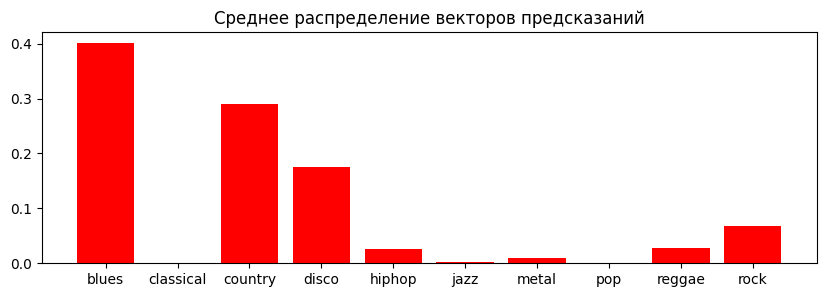

---------------------------------------------------------------
Файл: ./genres/disco/disco.00095.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: reggae - НЕВЕРНО.


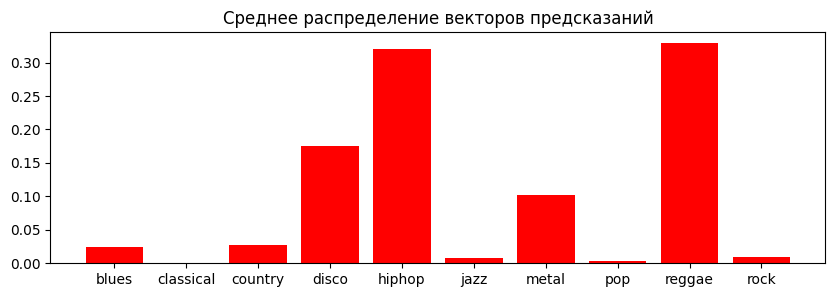

---------------------------------------------------------------
Файл: ./genres/disco/disco.00096.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: metal - НЕВЕРНО.


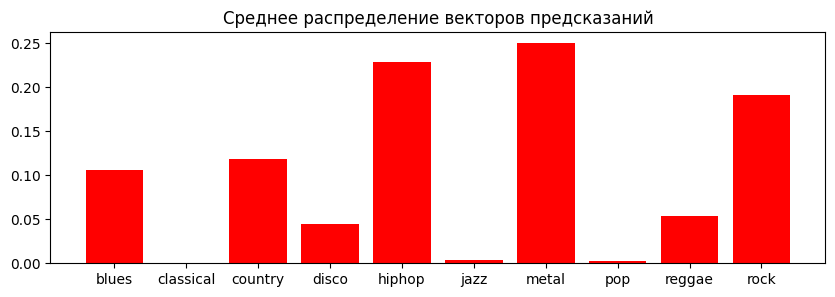

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00090.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: hiphop - ВЕРНО :-)


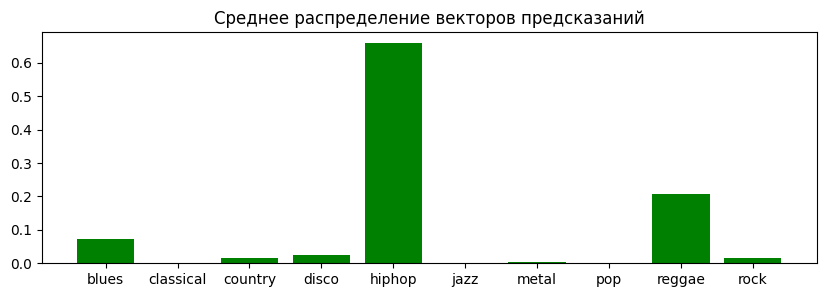

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00091.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: hiphop - ВЕРНО :-)


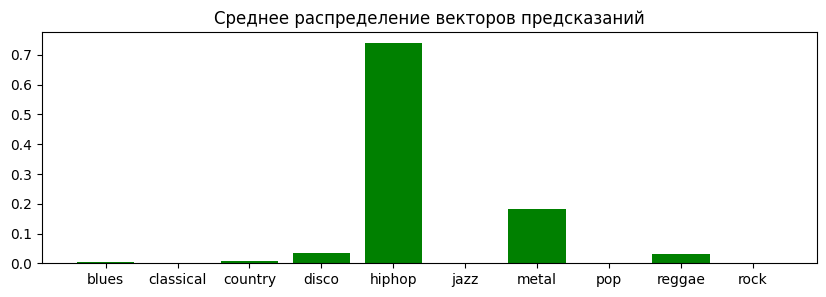

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00092.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: reggae - НЕВЕРНО.


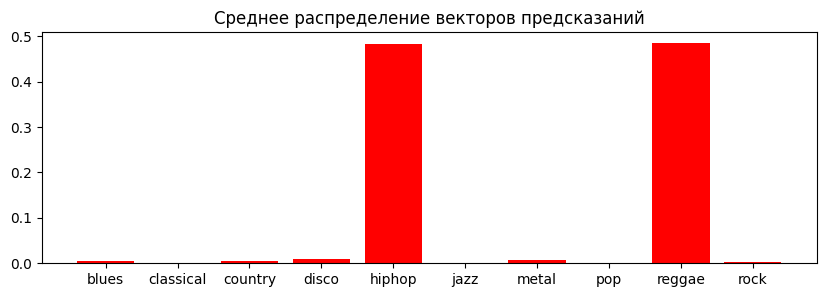

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00093.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: hiphop - ВЕРНО :-)


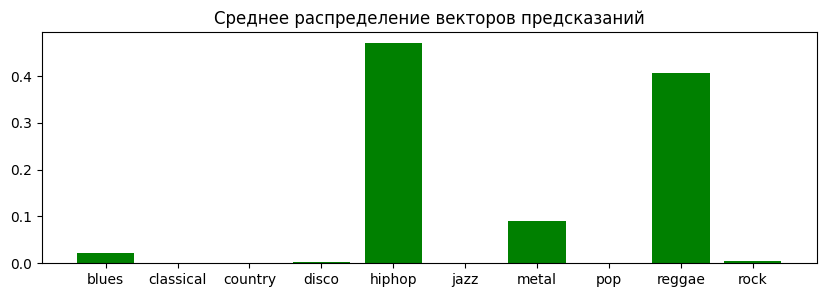

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00094.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: hiphop - ВЕРНО :-)


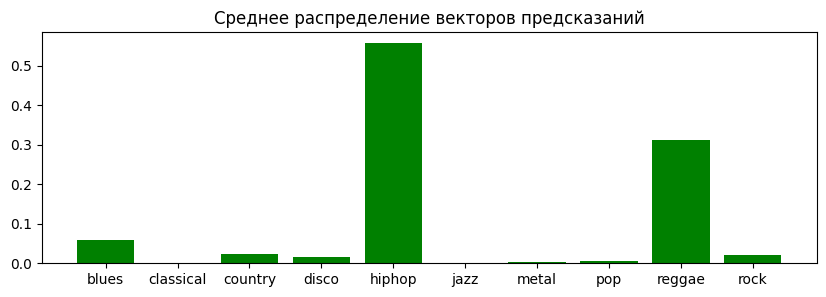

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00095.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 6ms/step
Классификация сети: hiphop - ВЕРНО :-)


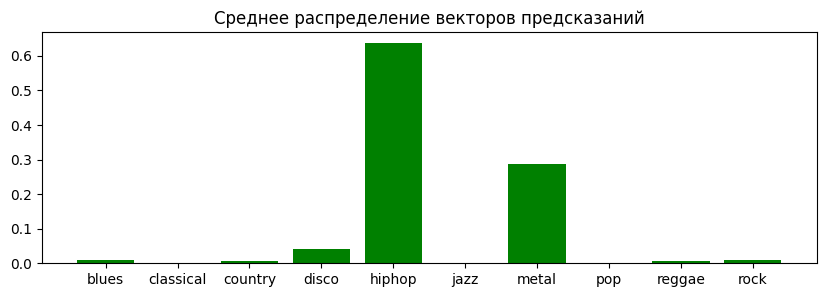

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00096.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: hiphop - ВЕРНО :-)


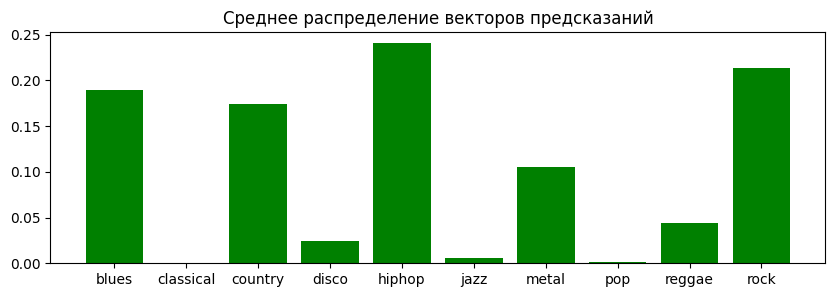

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00090.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - НЕВЕРНО.


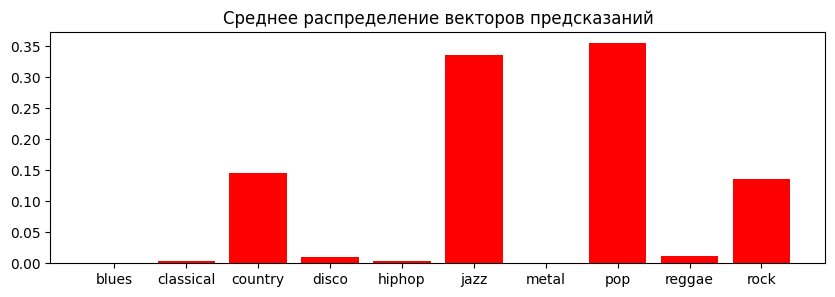

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00091.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: jazz - ВЕРНО :-)


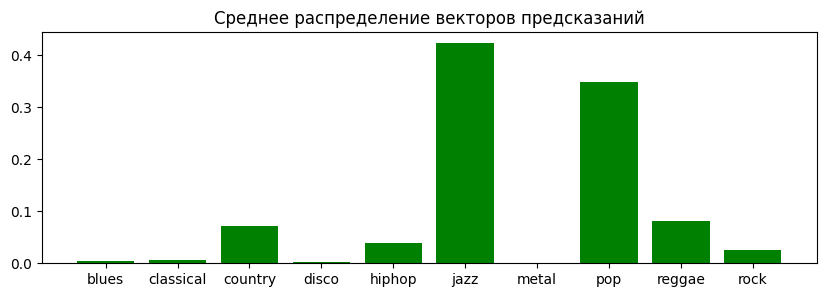

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00092.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: jazz - ВЕРНО :-)


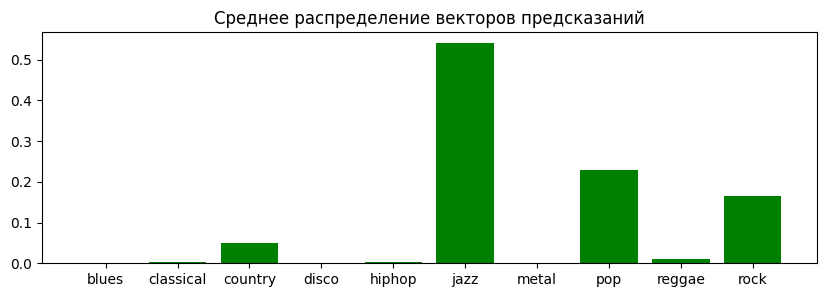

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00093.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - НЕВЕРНО.


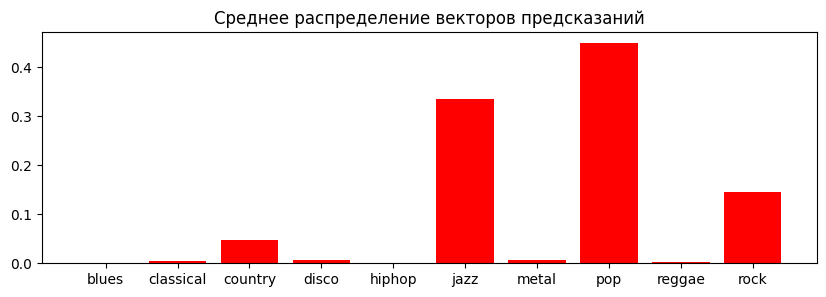

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00094.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: jazz - ВЕРНО :-)


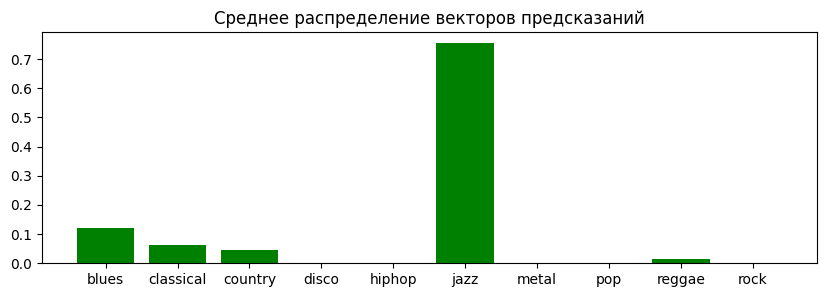

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00095.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: jazz - ВЕРНО :-)


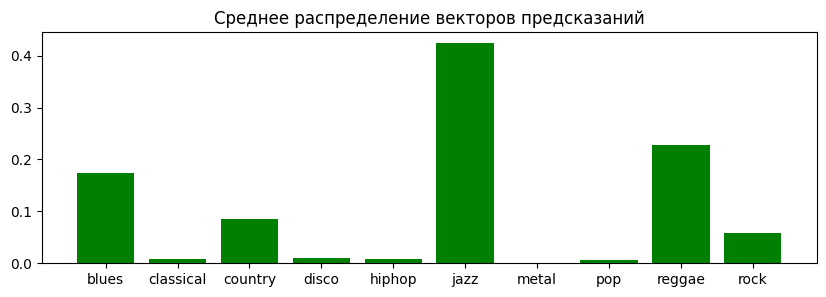

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00096.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: jazz - ВЕРНО :-)


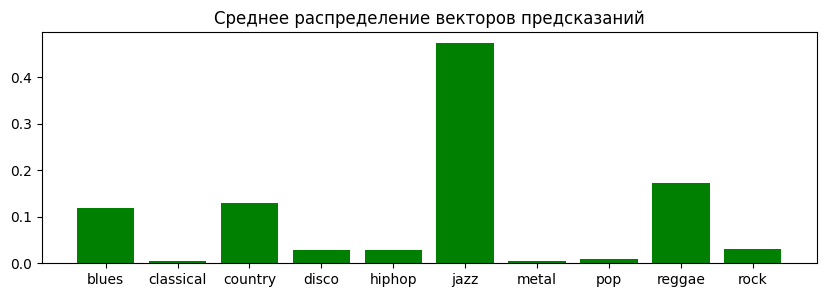

---------------------------------------------------------------
Файл: ./genres/metal/metal.00090.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: blues - НЕВЕРНО.


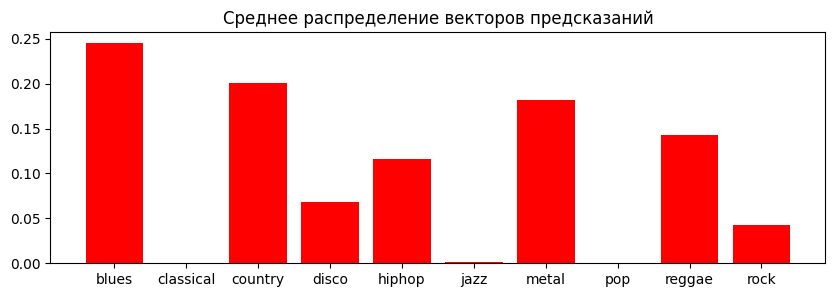

---------------------------------------------------------------
Файл: ./genres/metal/metal.00091.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 6ms/step
Классификация сети: country - НЕВЕРНО.


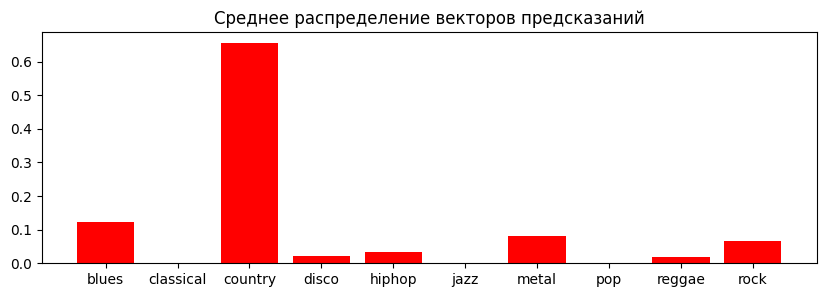

---------------------------------------------------------------
Файл: ./genres/metal/metal.00092.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: country - НЕВЕРНО.


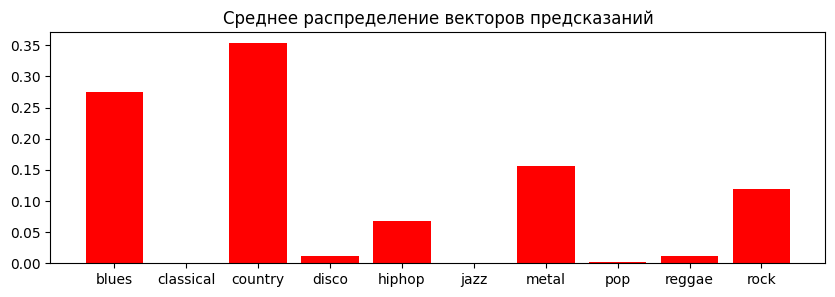

---------------------------------------------------------------
Файл: ./genres/metal/metal.00093.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: metal - ВЕРНО :-)


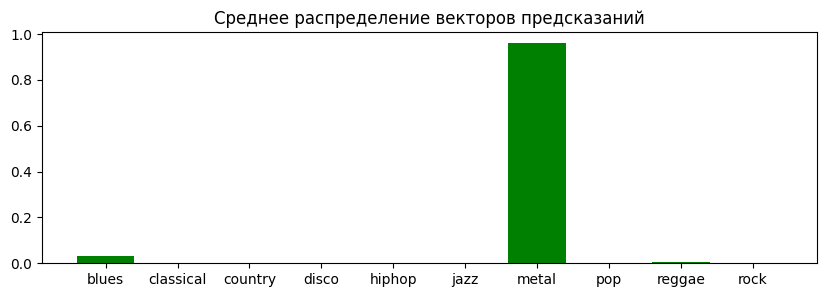

---------------------------------------------------------------
Файл: ./genres/metal/metal.00094.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: metal - ВЕРНО :-)


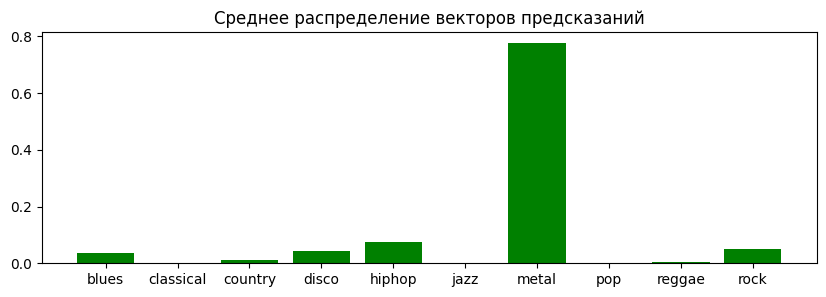

---------------------------------------------------------------
Файл: ./genres/metal/metal.00095.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: metal - ВЕРНО :-)


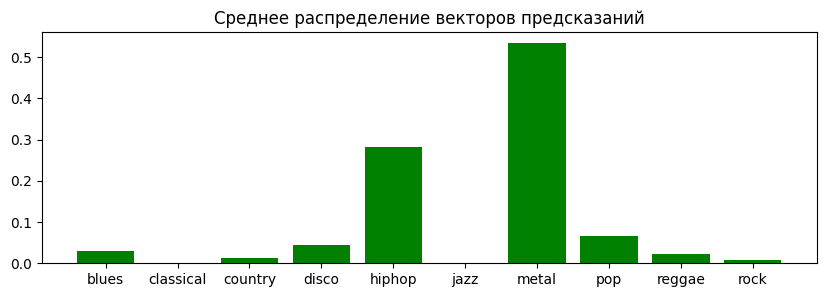

---------------------------------------------------------------
Файл: ./genres/metal/metal.00096.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: metal - ВЕРНО :-)


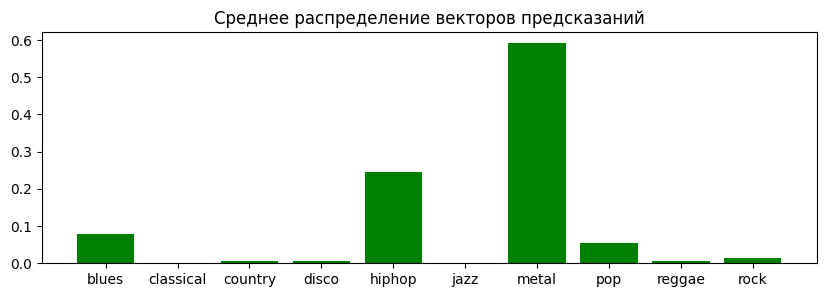

---------------------------------------------------------------
Файл: ./genres/pop/pop.00090.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: pop - ВЕРНО :-)


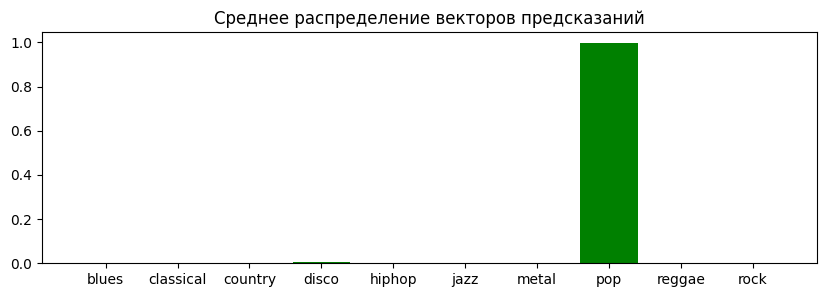

---------------------------------------------------------------
Файл: ./genres/pop/pop.00091.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - ВЕРНО :-)


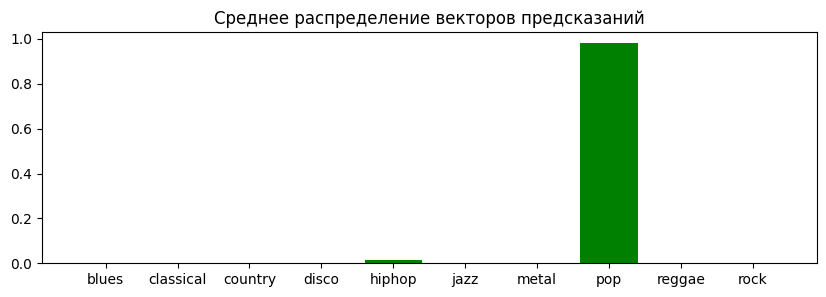

---------------------------------------------------------------
Файл: ./genres/pop/pop.00092.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - ВЕРНО :-)


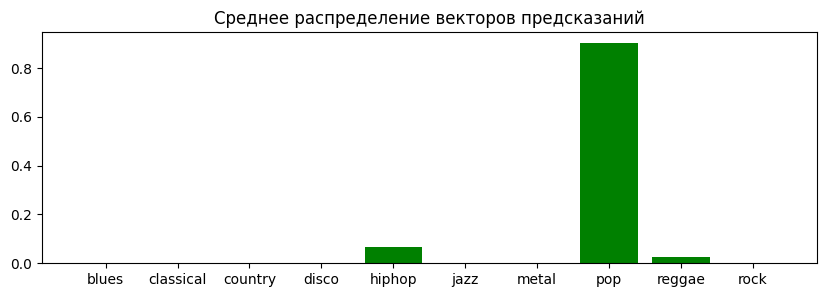

---------------------------------------------------------------
Файл: ./genres/pop/pop.00093.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 6ms/step
Классификация сети: pop - ВЕРНО :-)


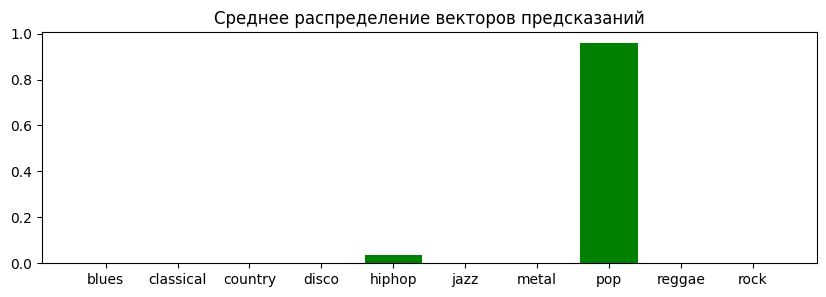

---------------------------------------------------------------
Файл: ./genres/pop/pop.00094.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: pop - ВЕРНО :-)


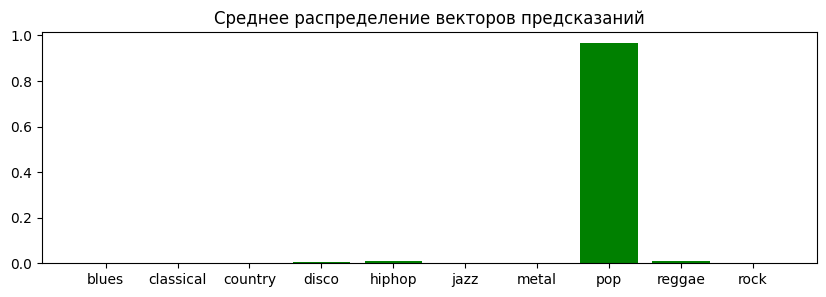

---------------------------------------------------------------
Файл: ./genres/pop/pop.00095.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - ВЕРНО :-)


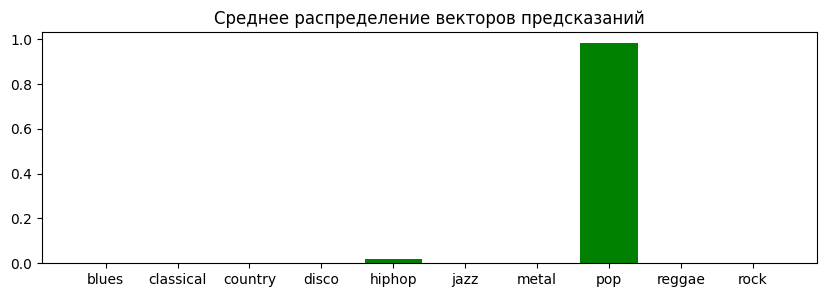

---------------------------------------------------------------
Файл: ./genres/pop/pop.00096.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - ВЕРНО :-)


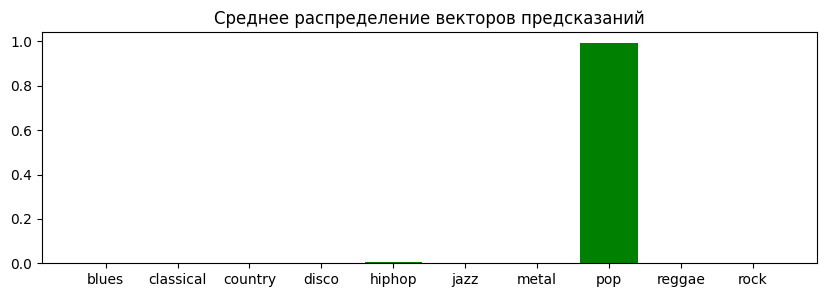

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00090.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: reggae - ВЕРНО :-)


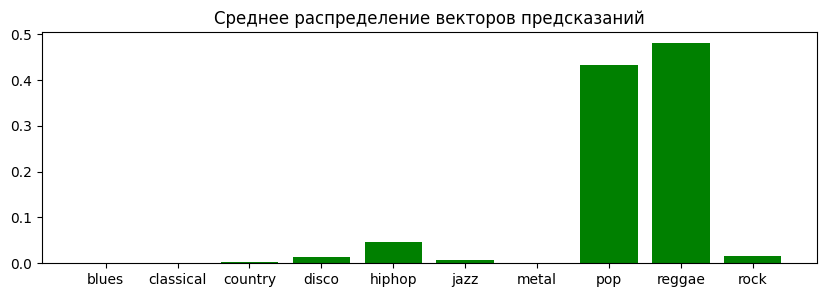

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00091.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: reggae - ВЕРНО :-)


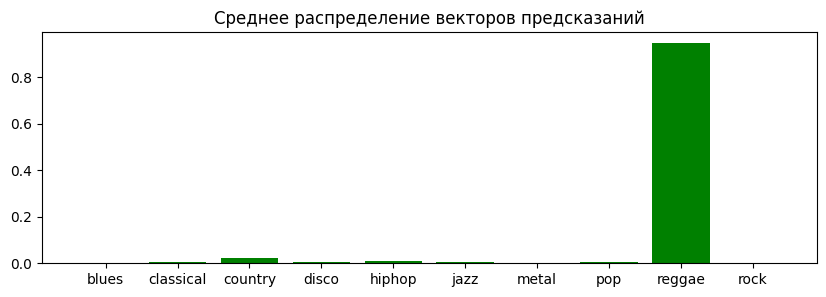

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00092.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: reggae - ВЕРНО :-)


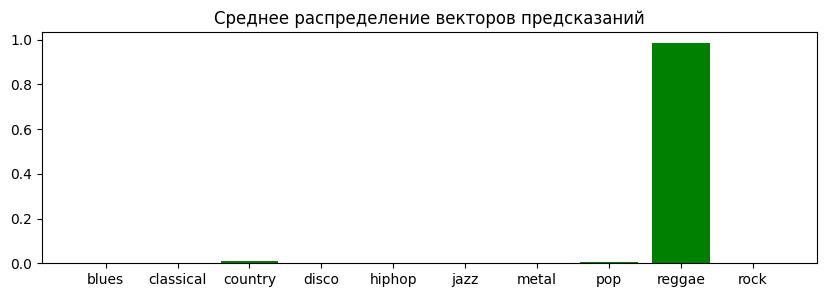

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00093.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: pop - НЕВЕРНО.


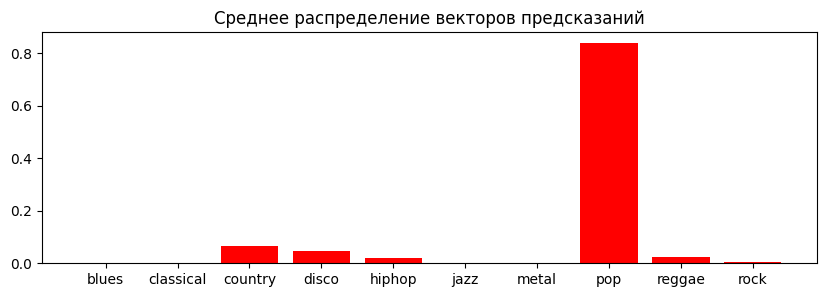

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00094.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: pop - НЕВЕРНО.


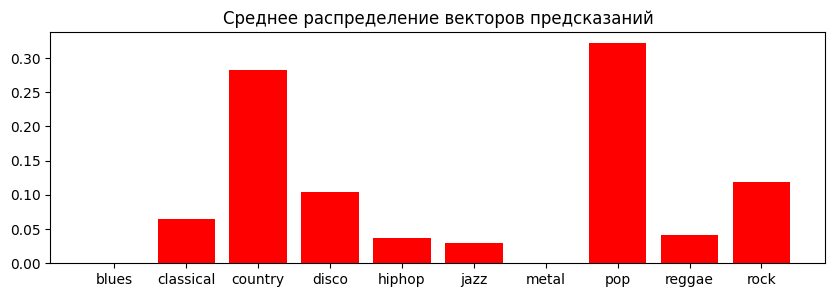

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00095.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: pop - НЕВЕРНО.


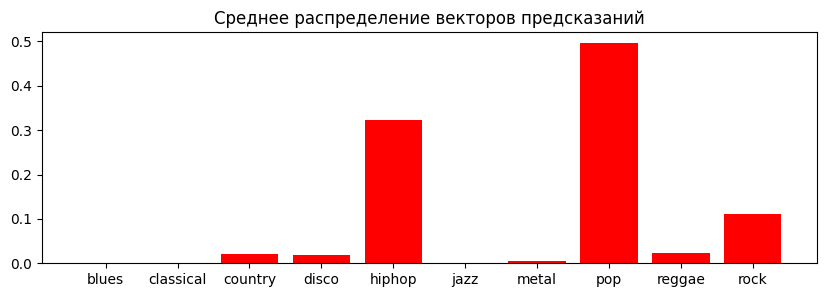

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00096.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 3ms/step
Классификация сети: reggae - ВЕРНО :-)


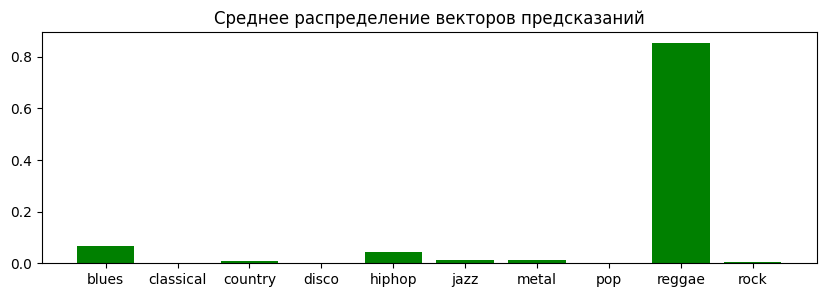

---------------------------------------------------------------
Файл: ./genres/rock/rock.00090.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: blues - НЕВЕРНО.


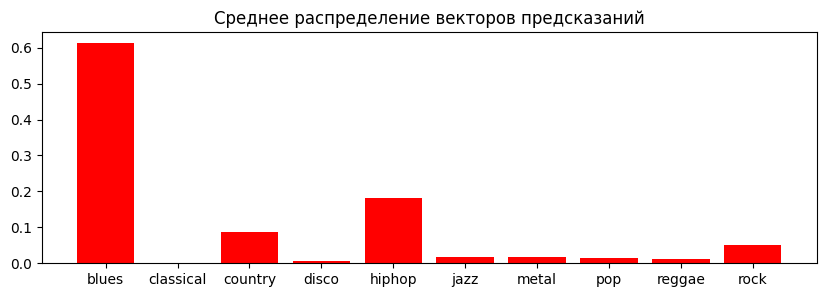

---------------------------------------------------------------
Файл: ./genres/rock/rock.00091.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: rock - ВЕРНО :-)


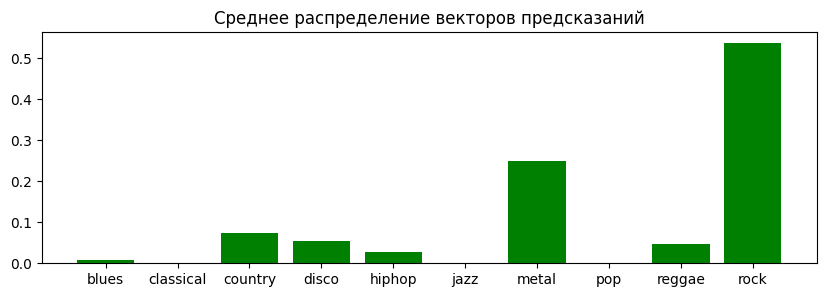

---------------------------------------------------------------
Файл: ./genres/rock/rock.00092.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 5ms/step
Классификация сети: rock - ВЕРНО :-)


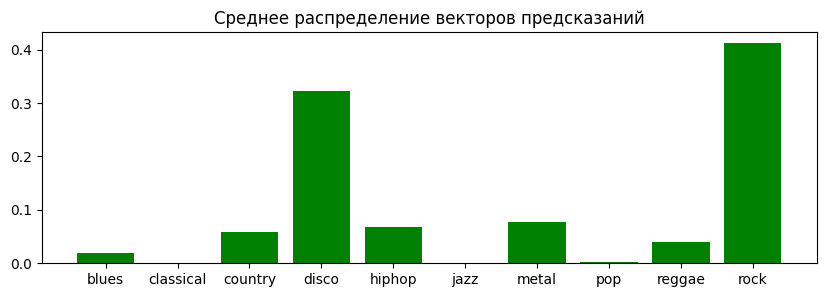

---------------------------------------------------------------
Файл: ./genres/rock/rock.00093.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: country - НЕВЕРНО.


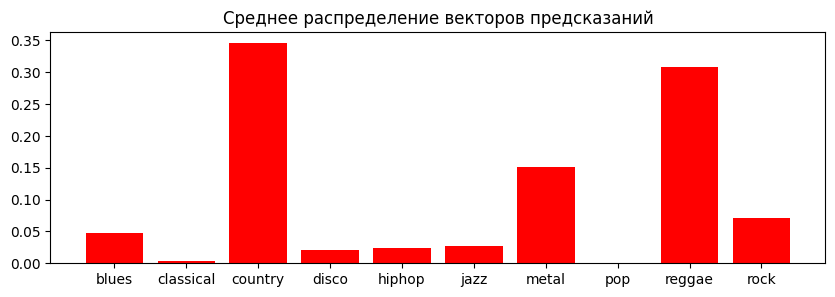

---------------------------------------------------------------
Файл: ./genres/rock/rock.00094.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: metal - НЕВЕРНО.


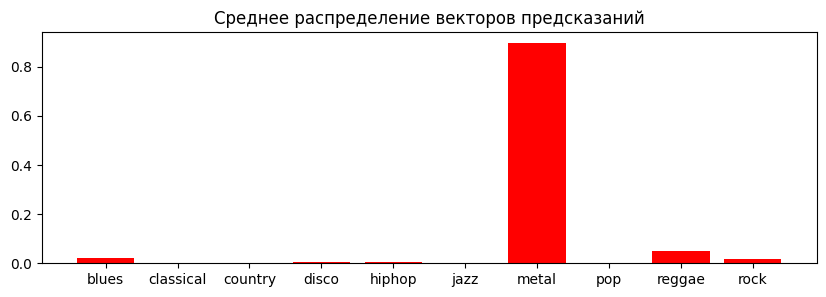

---------------------------------------------------------------
Файл: ./genres/rock/rock.00095.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: country - НЕВЕРНО.


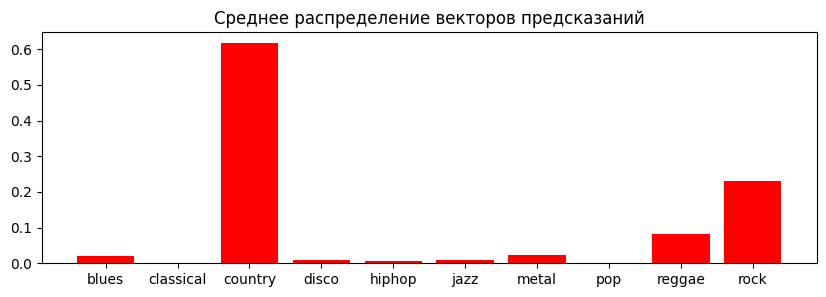

---------------------------------------------------------------
Файл: ./genres/rock/rock.00096.au
Векторы для предсказания: (1292, 37)
41/41 [==============================] - 0s 4ms/step
Классификация сети: country - НЕВЕРНО.


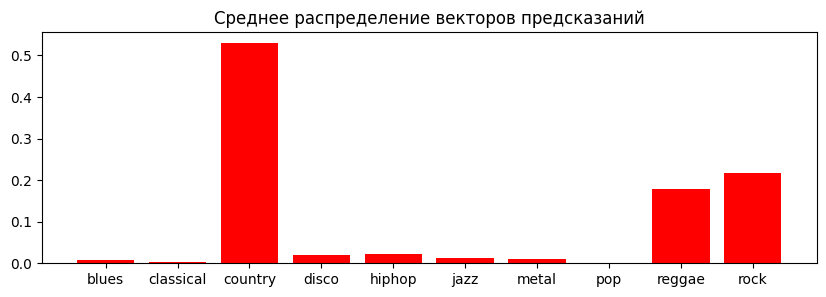

---------------------------------------------------------------
=== Обработано образцов: 70, из них распознано верно: 42, доля верных: 60.0% ===


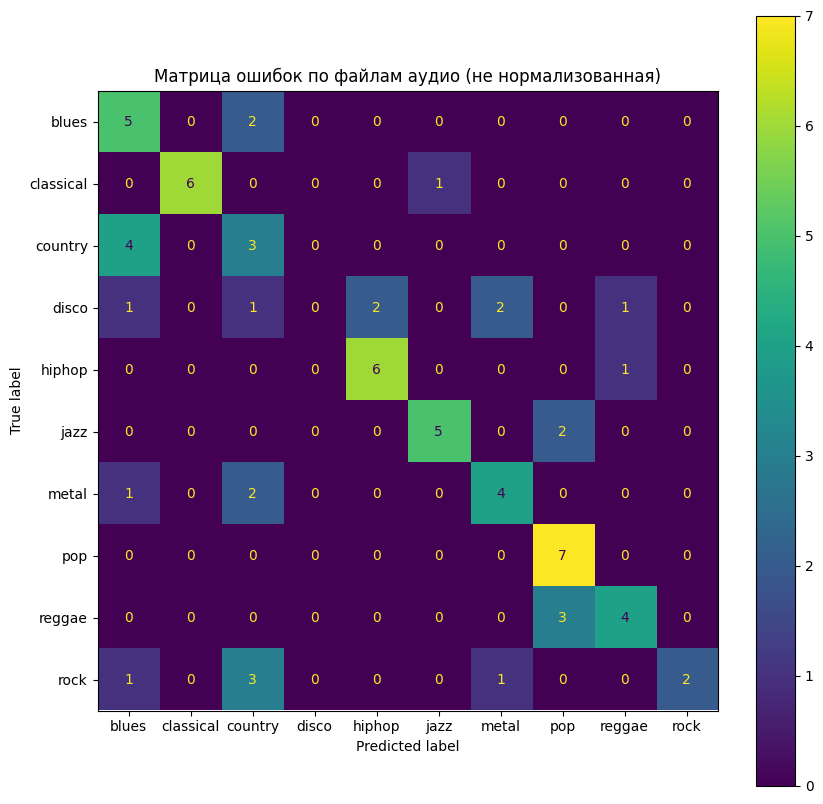

In [ ]:
# Визуализация классификации файлов из тестового набора
classify_test_files(model, x_scaler, 90, 7)